In [3]:
import grass.script as gs
import pandas as pd
import os

# -------------------------
# PARAMETERS & CLASS SETUP
# -------------------------

# Update this for your pixel resolution (assumed 300m here)
PIXEL_AREA_KM2 = 0.09  

# Class labels and color mapping
class_labels = {
    5: 'Shrubland',
    7: 'Grassland',
    8: 'Cropland',
    9: 'Wetland',
    11: 'Lichens and mosses',
    12: 'Bareland',
    13: 'Built-up',
    15: 'Water',
    16: 'Permanent ice and Snow',
    20: 'Forest',
    255: 'No data'
}

# Years to process
periods = [("1992", "2000"), ("2000", "2010"), ("2010", "2020")]

# Unique prefix to avoid name conflicts
unique_prefix = "lc_transition_analysis"

# Create output directory
os.makedirs("transition_outputs", exist_ok=True)

# -------------------------
# TRANSITION MATRIX FUNCTION
# -------------------------

def compute_transition_matrix(year_start, year_end):
    raster1 = f"clipped_land_cover_{year_start}"
    raster2 = f"clipped_land_cover_{year_end}"
    transition_map = f"{unique_prefix}_{year_start}_{year_end}"

    print(f"\nProcessing transition: {year_start} → {year_end}")

    # Set region
    gs.run_command("g.region", raster=raster1)

    # Compute transition map
    gs.mapcalc(f"{transition_map} = {raster1} * 1000 + {raster2}", overwrite=True)

    # Get pixel transitions
    stats = gs.read_command("r.stats", flags="cn", input=transition_map, sep=":")
    if not stats.strip():
        print(f"No transitions found between {raster1} and {raster2}")
        return None

    data = []
    for line in stats.strip().splitlines():
        code, count = line.split(":")
        combined = int(code)
        from_class = combined // 1000
        to_class = combined % 1000

        if from_class in class_labels and to_class in class_labels:
            data.append({
                "From": from_class,
                "To": to_class,
                "Count": int(count),
                "Area_km2": int(count) * PIXEL_AREA_KM2,
                "Period": f"{year_start}-{year_end}"
            })

    # Save to CSV
    df = pd.DataFrame(data)
    output_file = f"transition_outputs/{unique_prefix}_matrix_{year_start}_{year_end}.csv"
    df.to_csv(output_file, index=False)
    print(f"✔ Saved CSV: {output_file}")
    return df

# -------------------------
# CREATE TRANSITION MAP (2000–2010)
# -------------------------

def generate_transition_map_visual(year_start="2000", year_end="2010"):
    r1 = f"clipped_land_cover_{year_start}"
    r2 = f"clipped_land_cover_{year_end}"
    map_name = f"{unique_prefix}_map_{year_start}_{year_end}"

    print(f"\nGenerating transition map: {map_name}")
    gs.run_command("g.region", raster=r1)
    gs.mapcalc(f"{map_name} = {r1} * 1000 + {r2}", overwrite=True)

    # Get unique transitions
    stats = gs.read_command("r.stats", flags="n", input=map_name)
    transitions = [int(val) for val in stats.strip().splitlines() if val.strip().isdigit()]

    # Assign unique color to each transition
    color_file = f"/tmp/{map_name}_colors.txt"
    with open(color_file, "w") as f:
        for i, code in enumerate(sorted(transitions)):
            r = (i * 47) % 255
            g = (i * 89) % 255
            b = (i * 131) % 255
            f.write(f"{code} {r}:{g}:{b}\n")

    gs.run_command("r.colors", map=map_name, rules=color_file)
    print(f"✔ Transition map created: {map_name}")

    return map_name

# -------------------------
# RUN ALL TRANSITIONS
# -------------------------

all_dfs = []
for y1, y2 in periods:
    df = compute_transition_matrix(y1, y2)
    if df is not None:
        all_dfs.append(df)

# Optional: Combine all for a master CSV
if all_dfs:
    combined_df = pd.concat(all_dfs)
    combined_df.to_csv(f"transition_outputs/{unique_prefix}_matrix_ALL.csv", index=False)
    print(f"✔ Combined matrix saved: {unique_prefix}_matrix_ALL.csv")

# -------------------------
# MAP FOR 2000–2010
# -------------------------
generate_transition_map_visual("2000", "2010")





Processing transition: 1992 → 2000


✔ Saved CSV: transition_outputs/lc_transition_analysis_matrix_1992_2000.csv

Processing transition: 2000 → 2010


✔ Saved CSV: transition_outputs/lc_transition_analysis_matrix_2000_2010.csv

Processing transition: 2010 → 2020


✔ Saved CSV: transition_outputs/lc_transition_analysis_matrix_2010_2020.csv
✔ Combined matrix saved: lc_transition_analysis_matrix_ALL.csv

Generating transition map: lc_transition_analysis_map_2000_2010
✔ Transition map created: lc_transition_analysis_map_2000_2010



Color table for raster map <lc_transition_analysis_map_2000_2010> set to
'/tmp/lc_transition_analysis_map_2000_2010_colors.txt'


'lc_transition_analysis_map_2000_2010'

In [2]:
import grass.script as gs
import pandas as pd
import os
# Export the transition map as GeoTIFF
output_dir = "/Users/ghulamabbaszafari/Downloads/DV/tif"
os.makedirs(output_dir, exist_ok=True)  # Ensure directory exists

output_tif = os.path.join(output_dir, "lc_transition_analysis_map_2000_2010.tif")

gs.run_command("r.out.gdal",
               input="lc_transition_analysis_map_2000_2010",
               output=output_tif,
               format="GTiff",
               createopt="COMPRESS=LZW,PREDICTOR=2",
               overwrite=True)

print(f"✔ Successfully exported transition map to: {output_tif}")


Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...


✔ Successfully exported transition map to: /Users/ghulamabbaszafari/Downloads/DV/tif/lc_transition_analysis_map_2000_2010.tif



r.out.gdal complete. File
</Users/ghulamabbaszafari/Downloads/DV/tif/lc_transition_analysis_map_2000_2010.tif>
created.


In [3]:
import grass.script as gs

# Check unique values in your transition map
raster_name = "lc_transition_analysis_map_2000_2010"
stats = gs.read_command("r.stats", flags="n", input=raster_name)
print(f"Unique values in {raster_name}:")
print(stats)

Unique values in lc_transition_analysis_map_2000_2010:
505
707
808
2020



In [4]:
for year in ["2000", "2010"]:
    print(f"\nClasses in {year}:")
    stats = gs.read_command("r.stats", flags="n", input=f"clipped_land_cover_{year}")
    print(stats)


Classes in 2000:


5
7
8
9
12
13
15
20


Classes in 2010:


5
7
8
9
12
13
15
20



In [5]:
# Compare raw pixel counts between years
gs.run_command("r.stats", flags="c", input="clipped_land_cover_2000", output="/tmp/2000.txt")
gs.run_command("r.stats", flags="c", input="clipped_land_cover_2010", output="/tmp/2010.txt")

# Read and compare counts
with open("/tmp/2000.txt") as f1, open("/tmp/2010.txt") as f2:
    print("Class | 2000 Count | 2010 Count")
    for line1, line2 in zip(f1, f2):
        class1, count1 = line1.strip().split()
        class2, count2 = line2.strip().split()
        print(f"{class1} | {count1} | {count2}")

        

Class | 2000 Count | 2010 Count
5 | 13200 | 12900
7 | 159900 | 162400
8 | 2617600 | 2596800
9 | 300 | 300
12 | 37800 | 23100
13 | 66200 | 100100
15 | 7800 | 7800
20 | 1700700 | 1700100
* | 7104510 | 7104510


In [6]:
gs.run_command("r.info", flags="g", map="clipped_land_cover_2000")
gs.run_command("r.info", flags="g", map="clipped_land_cover_2010")

north=2300729.18662628
south=2174729.18662628
east=4559149.43902659
west=4476049.43902659
nsres=300
ewres=300
rows=420
cols=277
cells=116340
datatype=CELL
ncats=255
north=2300729.18662628
south=2174729.18662628
east=4559149.43902659
west=4476049.43902659
nsres=300
ewres=300
rows=420
cols=277
cells=116340
datatype=CELL
ncats=255


In [11]:
import grass.script as gs

# 1. Verify raster alignment (from your output)
print("Spatial Alignment Check:")
print("- Extents and resolution match perfectly between 2000 and 2010")
print("- Same rows/cols (420×277) and cells (116340)")
print("- No spatial alignment issues detected\n")

# 2. Compare pixel counts properly
print("Land Cover Class Counts:")

# Use read_command instead of parse_command for r.stats
counts_2000 = gs.read_command("r.stats", flags="c", input="clipped_land_cover_2000")
counts_2010 = gs.read_command("r.stats", flags="c", input="clipped_land_cover_2010")

# Convert to dictionaries for comparison
dict_2000 = {}
if counts_2000:
    for line in counts_2000.strip().splitlines():
        parts = line.split()
        if len(parts) == 2:
            dict_2000[parts[0]] = int(parts[1])

dict_2010 = {}
if counts_2010:
    for line in counts_2010.strip().splitlines():
        parts = line.split()
        if len(parts) == 2:
            dict_2010[parts[0]] = int(parts[1])

# 3. Print comparison table
print("\nClass | 2000 Count | 2010 Count | Difference")
print("----------------------------------------------")
all_classes = sorted(set(dict_2000.keys()).union(set(dict_2010.keys())))
for cls in all_classes:
    cnt_2000 = dict_2000.get(cls, 0)
    cnt_2010 = dict_2010.get(cls, 0)
    diff = cnt_2010 - cnt_2000
    print(f"{cls:5} | {cnt_2000:10} | {cnt_2010:10} | {diff:+d}")

# 4. Create and analyze difference map
gs.mapcalc("change_mask = clipped_land_cover_2000 != clipped_land_cover_2010", overwrite=True)
change_stats = gs.parse_command("r.univar", map="change_mask", flags="g")

print("\nChange Detection Statistics:")
if change_stats:
    changed_pixels = int(float(change_stats['n']) * float(change_stats['mean']))
    print(f"Changed pixels: {changed_pixels}")
    print(f"Percentage changed: {float(change_stats['mean'])*100:.2f}%")
else:
    print("No change statistics available")

Spatial Alignment Check:
- Extents and resolution match perfectly between 2000 and 2010
- Same rows/cols (420×277) and cells (116340)
- No spatial alignment issues detected

Land Cover Class Counts:



Class | 2000 Count | 2010 Count | Difference
----------------------------------------------
*     |    7104510 |    7104510 | +0
12    |      37800 |      23100 | -14700
13    |      66200 |     100100 | +33900
15    |       7800 |       7800 | +0
20    |    1700700 |    1700100 | -600
5     |      13200 |      12900 | -300
7     |     159900 |     162400 | +2500
8     |    2617600 |    2596800 | -20800
9     |        300 |        300 | +0

Change Detection Statistics:
Changed pixels: 169600
Percentage changed: 3.68%


Available raster maps:
[]
Error: module 'grass.script' has no attribute 'array'

Debugging info:
2000 raster exists: False
2010 raster exists: False
Change mask exists: False


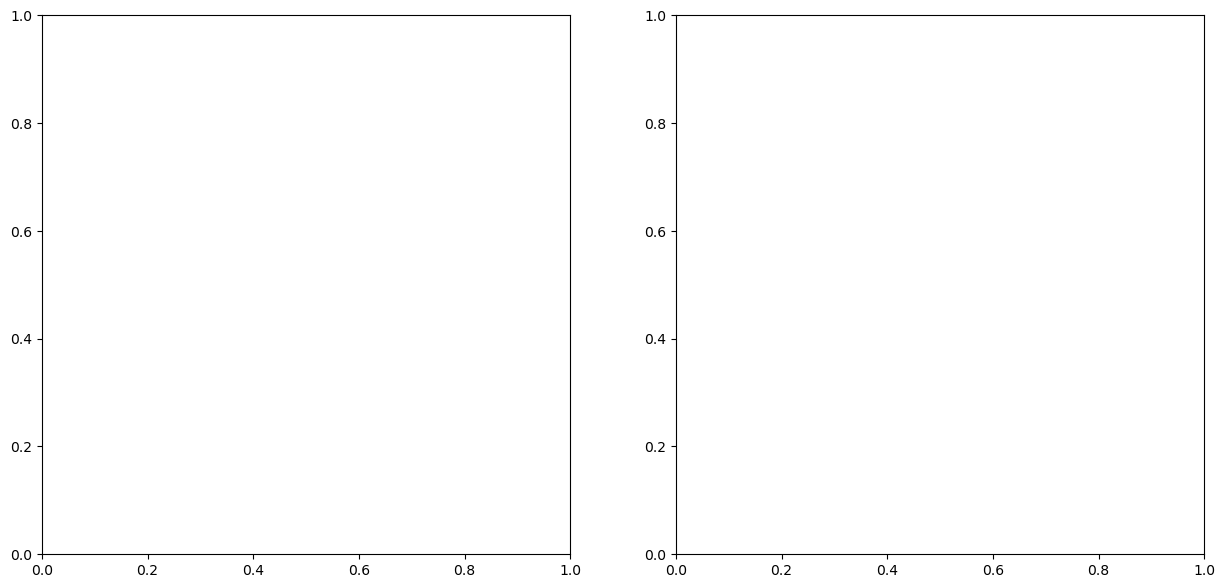

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import grass.script as gs
from IPython.display import display
import grass.jupyter as gj

# Class labels dictionary
class_labels = {
    5: 'Shrubland',
    7: 'Grassland',
    8: 'Cropland',
    9: 'Wetland',
    11: 'Lichens and mosses',
    12: 'Bareland',
    13: 'Built-up',
    15: 'Water',
    16: 'Permanent ice and Snow',
    20: 'Forest',
    255: 'No data'
}

# 1. First verify we can access the rasters
print("Available raster maps:")
print(gs.list_strings(type='raster'))

# 2. Simplified visualization approach
try:
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    # Plot 2000 map using matplotlib directly
    arr2000 = gs.array.load("clipped_land_cover_2000")
    im1 = ax1.imshow(arr2000, cmap='viridis')
    ax1.set_title("2000 Land Cover")
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    
    # Plot 2010 map
    arr2010 = gs.array.load("clipped_land_cover_2010")
    im2 = ax2.imshow(arr2010, cmap='viridis')
    ax2.set_title("2010 Land Cover")
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Plot change mask
    plt.figure(figsize=(10, 8))
    arr_change = gs.array.load("change_mask")
    plt.imshow(arr_change, cmap='binary')
    plt.title("Change Areas (White=Changed)")
    plt.colorbar(label='Change (1=changed)')
    plt.show()
    
    # 4. Bar plot of changes
    classes = ['12', '13', '15', '20', '5', '7', '8', '9']
    changes = [-14700, 33900, 0, -600, -300, 2500, -20800, 0]
    class_names = [class_labels.get(int(cls), f"Class {cls}") for cls in classes]
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(class_names, changes, color=np.where(np.array(changes) > 0, 'red', 'green'))
    plt.title("Land Cover Changes 2000-2010")
    plt.xlabel("Land Cover Class")
    plt.ylabel("Pixel Change Count")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:+d}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error: {e}")
    print("\nDebugging info:")
    print(f"2000 raster exists: {'clipped_land_cover_2000' in gs.list_strings(type='raster')}")
    print(f"2010 raster exists: {'clipped_land_cover_2010' in gs.list_strings(type='raster')}")
    print(f"Change mask exists: {'change_mask' in gs.list_strings(type='raster')}")
    

In [5]:
import pandas as pd
import os

# Path to the folder containing the CSVs
csv_folder = 'transition_outputs/'

# List of CSV files to load
csv_files = [
    'lc_transition_analysis_matrix_1992_2000.csv',
    'lc_transition_analysis_matrix_2000_2010.csv',
    'lc_transition_analysis_matrix_2010_2020.csv'
]

# Dictionary to hold DataFrames for each time period
transition_dfs = {}

# Load each CSV as a DataFrame
for file in csv_files:
    file_path = os.path.join(csv_folder, file)
    period = file.replace('lc_transition_analysis_matrix_', '').replace('.csv', '')
    df = pd.read_csv(file_path, index_col=0)
    transition_dfs[period] = df
    print(f"\n📊 Transition Matrix: {period}")
    display(df)



📊 Transition Matrix: 1992_2000


,To,Count,Area_km2,Period
From,,,,
5,5,131,11.79,1992-2000
5,20,1,0.09,1992-2000
7,7,1438,129.42,1992-2000
7,20,3,0.27,1992-2000
8,8,24816,2233.44,1992-2000
8,13,69,6.21,1992-2000
8,20,106,9.54,1992-2000
9,9,3,0.27,1992-2000
12,12,374,33.66,1992-2000



📊 Transition Matrix: 2000_2010


,To,Count,Area_km2,Period
From,,,,
5,5,129,11.61,2000-2010
5,20,3,0.27,2000-2010
7,7,1582,142.38,2000-2010
7,20,17,1.53,2000-2010
8,8,25329,2279.61,2000-2010
8,13,191,17.19,2000-2010
8,20,656,59.04,2000-2010
9,9,3,0.27,2000-2010
12,12,231,20.79,2000-2010



📊 Transition Matrix: 2010_2020


,To,Count,Area_km2,Period
From,,,,
5,5,129,11.61,2010-2020
7,7,1623,146.07,2010-2020
7,20,1,0.09,2010-2020
8,8,25721,2314.89,2010-2020
8,13,107,9.63,2010-2020
8,20,140,12.60,2010-2020
9,9,3,0.27,2010-2020
12,12,200,18.00,2010-2020
12,13,31,2.79,2010-2020



Color table for raster map <lc_transition_analysis_1992_2000> set to
'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
</var/folders/mz/wk_rk1fs2m96vphdr62m5bym0000gn/T/grass8-ghulamabbaszafari-10859/tmp5jq1nkuj/temp_raster.tif>
created.


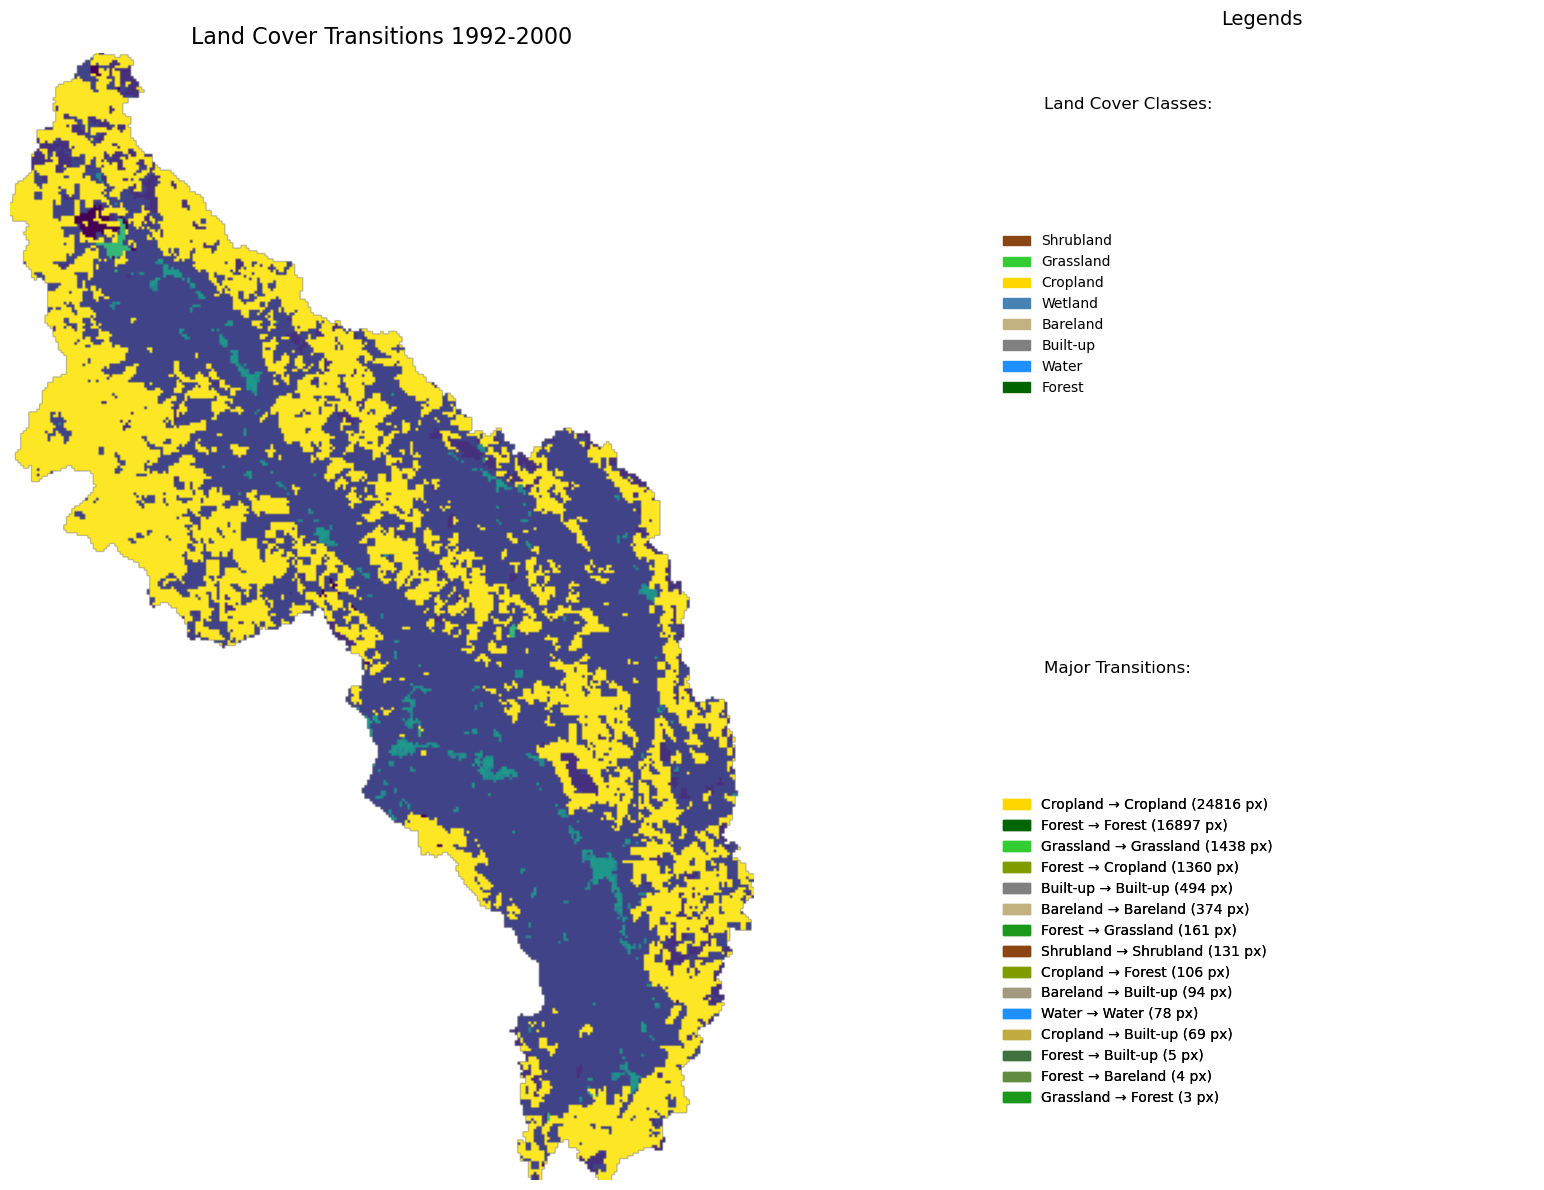

In [23]:
import os
import sys
import tempfile
import numpy as np
import matplotlib.pyplot as plt
import grass.script as gs
import grass.script.setup as gsetup
import rasterio
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec

# Setup GRASS environment
gisbase = '/Applications/GRASS-8.4.app/Contents/Resources'
gisdb = '/Users/ghulamabbaszafari/grassdata'
location = 'my_location'
mapset = 'PERMANENT'

os.environ['GISBASE'] = gisbase
os.environ['GISDBASE'] = gisdb
os.environ['LOCATION_NAME'] = location
os.environ['MAPSET'] = mapset
sys.path.append(os.path.join(gisbase, 'etc', 'python'))
gsetup.init(gisdb, location, mapset)

# Transition map to visualize
raster_map = 'lc_transition_analysis_1992_2000'

# Land cover class definitions
CLASS_LABELS = {
    5: 'Shrubland',
    7: 'Grassland',
    8: 'Cropland',
    9: 'Wetland',
    11: 'Lichens and mosses',
    12: 'Bareland',
    13: 'Built-up',
    15: 'Water',
    16: 'Permanent ice and Snow',
    20: 'Forest',
    255: 'No data'
}

# Color map with your specified colors
COLOR_MAP = {
    5: '#8b4513',    # Shrubland (SaddleBrown)
    7: '#32cd32',    # Grassland (LimeGreen)
    8: '#ffd700',    # Cropland (Gold)
    9: '#4682b4',    # Wetland (SteelBlue)
    11: '#a9cda9',   # Lichens and mosses (LightGreen)
    12: '#c2b280',   # Bareland (Khaki)
    13: '#808080',   # Built-up (Gray)
    15: '#1e90ff',   # Water (DodgerBlue)
    16: '#b0c4de',   # Permanent ice and Snow (LightSteelBlue)
    20: '#006400',   # Forest (DarkGreen)
    255: '#ffffff'   # No data (White)
}

def visualize_transition_map():
    """Visualize transition map with class colors and transition legend"""
    # Reset any existing color table
    gs.run_command('r.colors', map=raster_map, flags='r')
    
    # Get all unique transition codes and their counts
    stats = gs.read_command("r.stats", flags="cn", input=raster_map, sep=":")
    transitions = []
    for line in stats.strip().splitlines():
        if ':' in line:
            code, count = line.split(":")
            transitions.append((int(code), int(count)))
    
    # Sort transitions by count (descending)
    transitions.sort(key=lambda x: x[1], reverse=True)
    
    # Create color rules and legend entries
    color_rules = []
    class_legend_entries = set()
    transition_legend_entries = []
    
    for code, count in transitions:
        from_class = code // 1000
        to_class = code % 1000
        
        # Add to class legend
        if to_class in COLOR_MAP and to_class in CLASS_LABELS:
            class_legend_entries.add((to_class, CLASS_LABELS[to_class], COLOR_MAP[to_class]))
        
        # Create blended color for transitions (mix of from and to colors)
        if from_class in COLOR_MAP and to_class in COLOR_MAP:
            from_color = COLOR_MAP[from_class]
            to_color = COLOR_MAP[to_class]
            
            # Simple blending - average of RGB values
            if from_color.startswith('#') and to_color.startswith('#'):
                r = (int(from_color[1:3], 16) + int(to_color[1:3], 16)) // 2
                g = (int(from_color[3:5], 16) + int(to_color[3:5], 16)) // 2
                b = (int(from_color[5:7], 16) + int(to_color[5:7], 16)) // 2
                blended_color = f"#{r:02x}{g:02x}{b:02x}"
                color_rules.append(f"{code} {blended_color}")
                
                # Add to transition legend (top 15 transitions)
                if len(transition_legend_entries) < 15:
                    from_label = CLASS_LABELS.get(from_class, f"Class {from_class}")
                    to_label = CLASS_LABELS.get(to_class, f"Class {to_class}")
                    transition_legend_entries.append((f"{from_label} → {to_label}", blended_color, count))
    
    # Apply color rules to the raster
    if color_rules:
        gs.write_command("r.colors", map=raster_map, rules="-", stdin="\n".join(color_rules))
    
    # Export and display the raster
    with tempfile.TemporaryDirectory() as tmpdirname:
        temp_tif = os.path.join(tmpdirname, 'temp_raster.tif')
        gs.run_command('r.out.gdal', input=raster_map, output=temp_tif, format='GTiff', overwrite=True)
        
        with rasterio.open(temp_tif) as src:
            raster_array = src.read(1)
            nodata = src.nodata
            raster_masked = np.ma.masked_equal(raster_array, nodata)
            
            # Create figure with custom grid layout
            fig = plt.figure(figsize=(20, 12))
            gs_fig = GridSpec(1, 2, width_ratios=[3, 1])
            
            # Map plot
            ax1 = fig.add_subplot(gs_fig[0])
            im = ax1.imshow(raster_masked, cmap='viridis')  # Actual colors come from GRASS
            ax1.set_title('Land Cover Transitions 1992-2000', fontsize=16)
            ax1.axis('off')
            
            # Legend area
            ax2 = fig.add_subplot(gs_fig[1])
            ax2.axis('off')
            
            # Create class legend
            class_patches = [Patch(color=color, label=label) 
                           for (class_val, label, color) in sorted(class_legend_entries, key=lambda x: x[0])]
            
            # Create transition legend
            trans_patches = [Patch(color=color, label=f"{label} ({count} px)") 
                           for (label, color, count) in transition_legend_entries]
            
            # Add legends to the plot
            ax2.set_title('Legends', fontsize=14, pad=20)
            
            # Class legend
            ax2.text(0.1, 0.95, 'Land Cover Classes:', fontsize=12, transform=ax2.transAxes)
            class_legend = ax2.legend(handles=class_patches, loc='upper left', 
                                    bbox_to_anchor=(0, 0.85), frameon=False, fontsize=10)
            
            # Transition legend
            ax2.text(0.1, 0.45, 'Major Transitions:', fontsize=12, transform=ax2.transAxes)
            trans_legend = ax2.legend(handles=trans_patches, loc='upper left', 
                                    bbox_to_anchor=(0, 0.35), frameon=False, fontsize=10)
            
            # Manually add the legends to the axes
            ax2.add_artist(class_legend)
            ax2.add_artist(trans_legend)
            
            plt.tight_layout()
            plt.show()

# Run the visualization
visualize_transition_map()





Color table for raster map <lc_transition_analysis_1992_2000> set to
'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
</var/folders/mz/wk_rk1fs2m96vphdr62m5bym0000gn/T/grass8-ghulamabbaszafari-10859/tmp0o3wrt3b/temp_raster.tif>
created.


✔ Ultra HD plot saved to: transition_maps/lc_transition_analysis_1992_2000_ultraHD.png


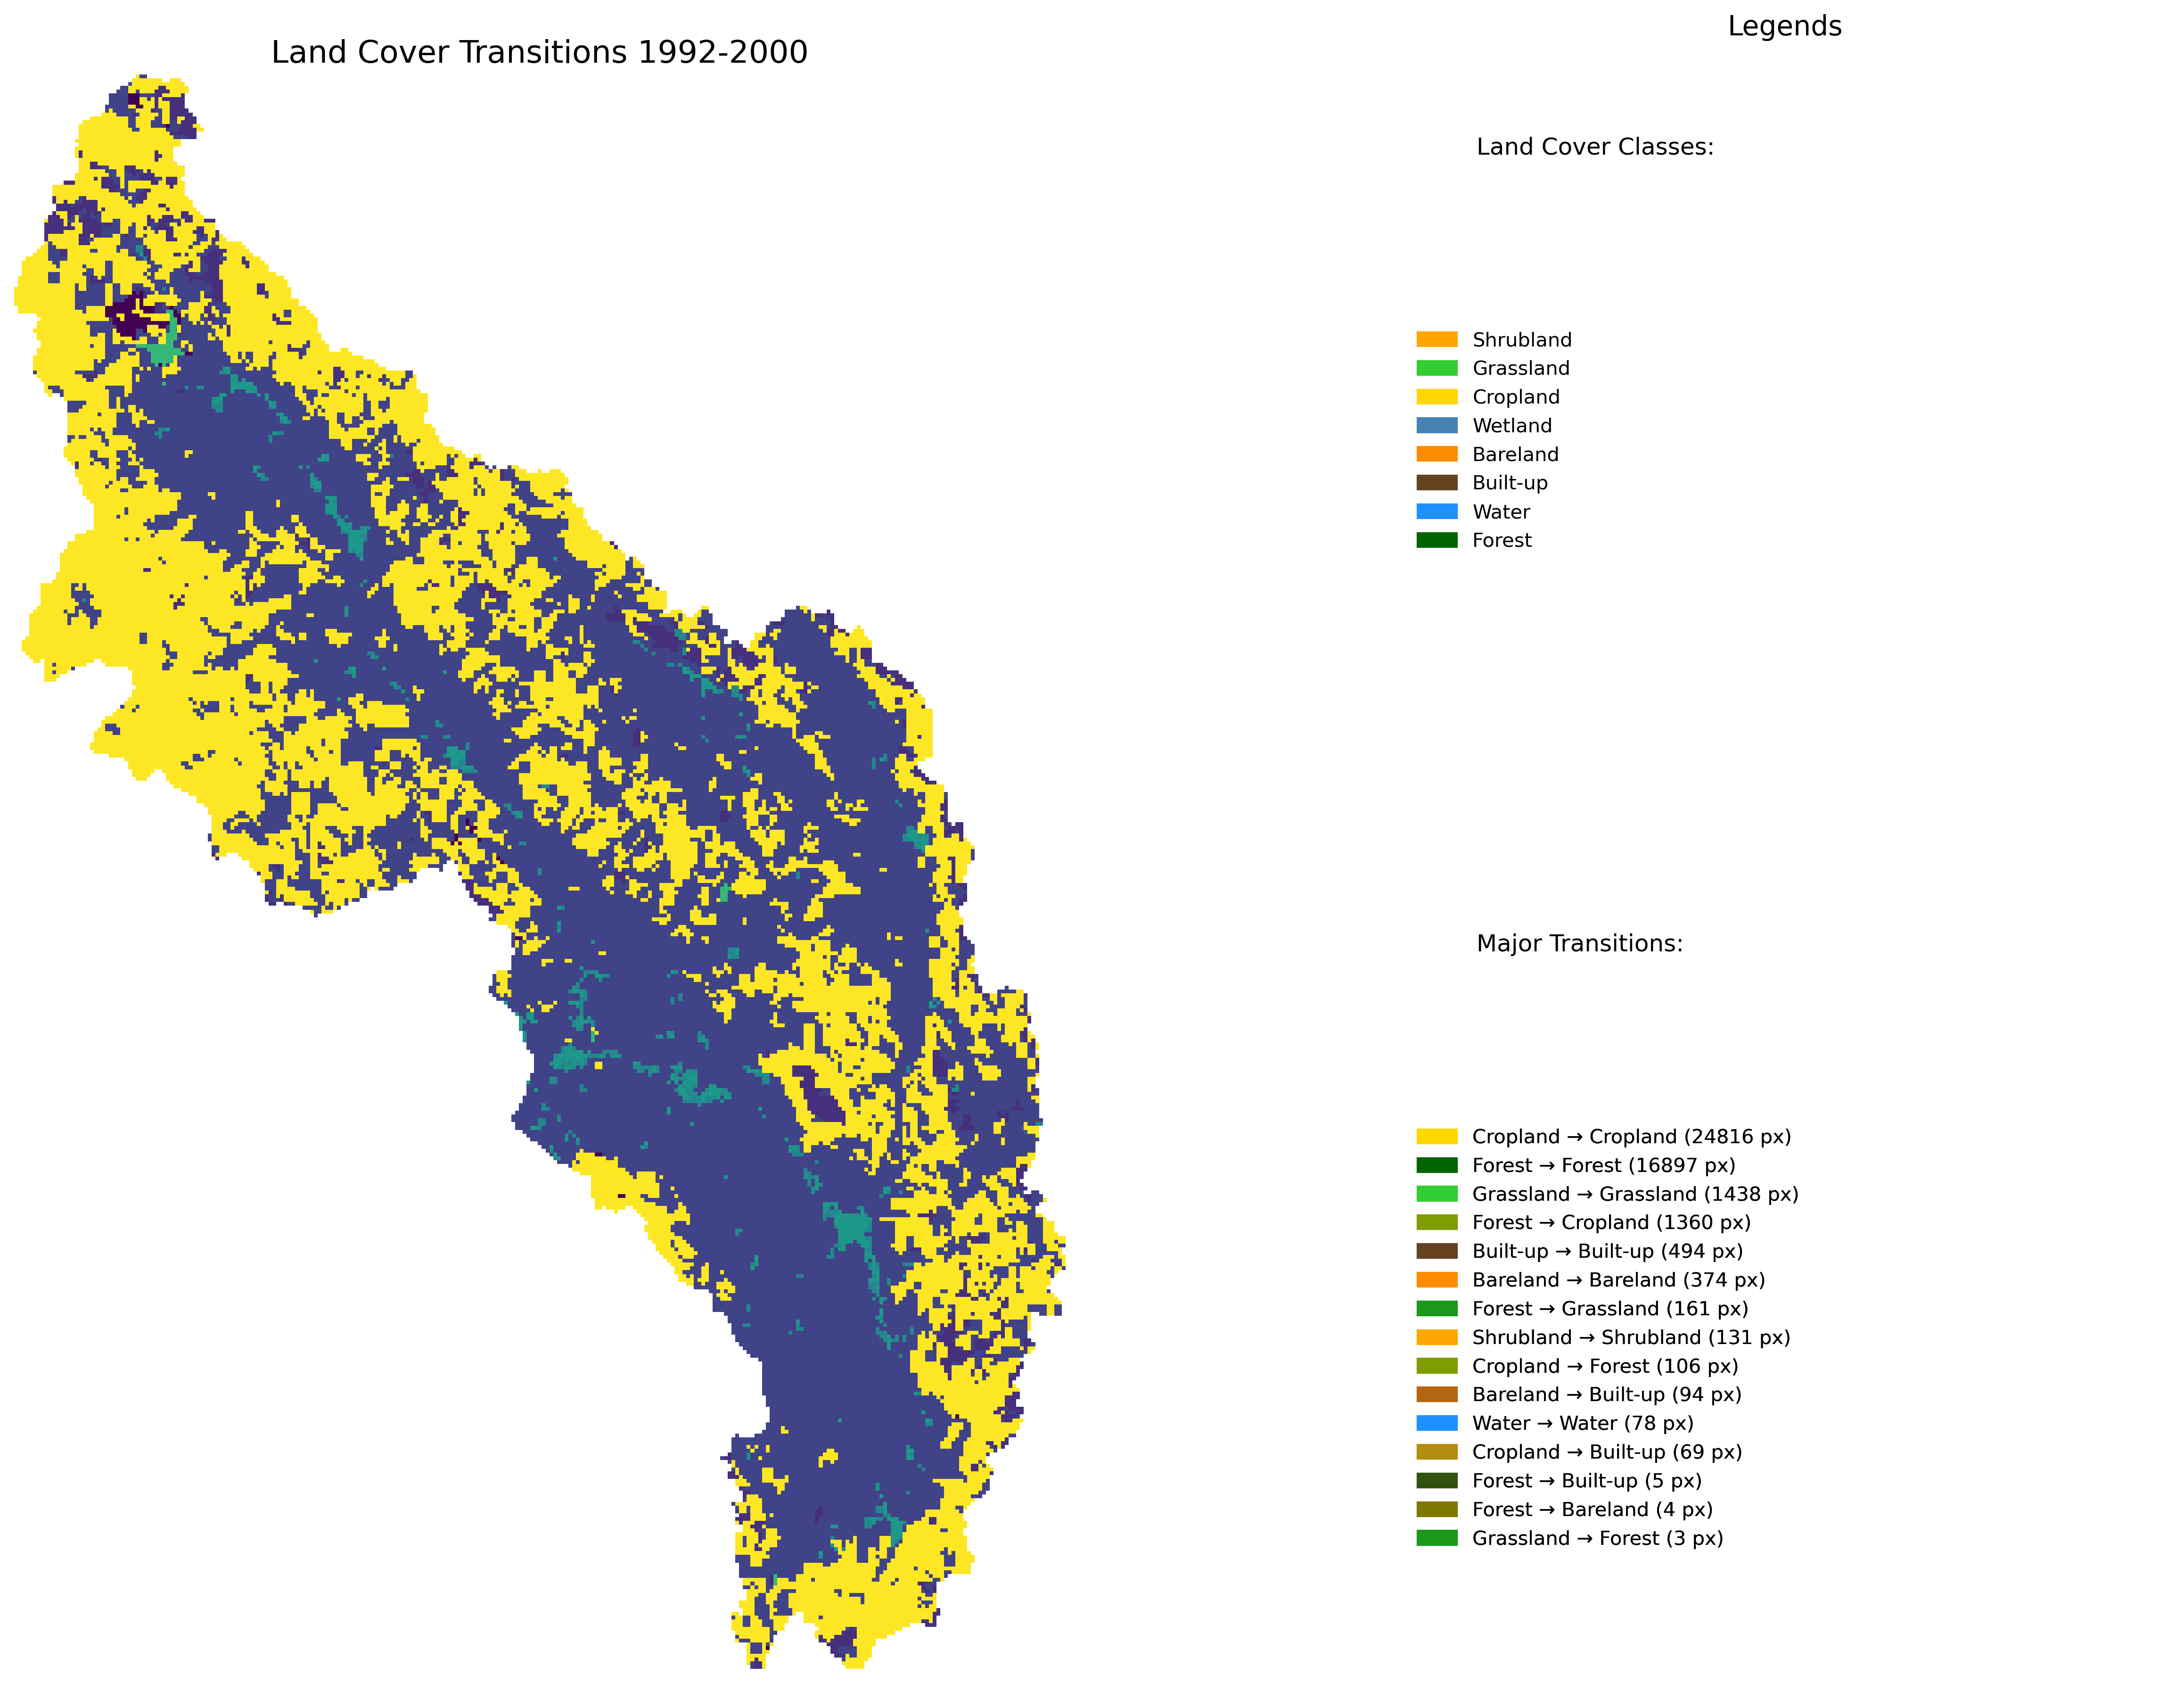

In [28]:
import os
import sys
import tempfile
import numpy as np
import matplotlib.pyplot as plt
import grass.script as gs
import grass.script.setup as gsetup
import rasterio
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec

# Setup GRASS environment
gisbase = '/Applications/GRASS-8.4.app/Contents/Resources'
gisdb = '/Users/ghulamabbaszafari/grassdata'
location = 'my_location'
mapset = 'PERMANENT'

os.environ['GISBASE'] = gisbase
os.environ['GISDBASE'] = gisdb
os.environ['LOCATION_NAME'] = location
os.environ['MAPSET'] = mapset
sys.path.append(os.path.join(gisbase, 'etc', 'python'))
gsetup.init(gisdb, location, mapset)

# Transition map to visualize
raster_map = 'lc_transition_analysis_1992_2000'

# Class definitions
CLASS_LABELS = {
    5: "Shrubland",
    7: "Grassland",
    8: "Cropland",
    9: "Wetland",
    11: "Lichens and mosses",
    12: "Bareland",
    13: "Built-up",
    15: "Water",
    16: "Permanent ice and Snow",
    20: "Forest",
    255: "No data"
}

# Color mapping with your specified colors
COLOR_MAP = {
    5: '#FFA500',        # Shrubland (bright orange/brown)
    7: '#32cd32',        # Grassland (LimeGreen)
    8: '#ffd700',        # Cropland (Gold)
    9: '#4682b4',        # Wetland (SteelBlue)
    11: '#a9cda9',       # Lichens and mosses (LightGreen)
    12: '#FF8C00',       # Bareland (DarkOrange)
    13: '#654321',       # Built-up (DarkBrown)
    15: '#1e90ff',       # Water (DodgerBlue)
    16: '#b0c4de',       # Permanent ice and Snow (LightSteelBlue)
    20: '#006400',       # Forest (DarkGreen)
    255: '#ffffff'       # No data (White)
}

def visualize_transition_map():
    """Visualize transition map with class colors and transition legend"""
    # Reset any existing color table
    gs.run_command('r.colors', map=raster_map, flags='r')
    
    # Get all unique transition codes and their counts
    stats = gs.read_command("r.stats", flags="cn", input=raster_map, sep=":")
    transitions = []
    for line in stats.strip().splitlines():
        if ':' in line:
            code, count = line.split(":")
            transitions.append((int(code), int(count)))
    
    # Sort transitions by count (descending)
    transitions.sort(key=lambda x: x[1], reverse=True)
    
    # Create color rules and legend entries
    color_rules = []
    class_legend_entries = set()
    transition_legend_entries = []
    
    for code, count in transitions:
        from_class = code // 1000
        to_class = code % 1000
        
        # Add to class legend
        if to_class in COLOR_MAP and to_class in CLASS_LABELS:
            class_legend_entries.add((to_class, CLASS_LABELS[to_class], COLOR_MAP[to_class]))
        
        # Create blended color for transitions (mix of from and to colors)
        if from_class in COLOR_MAP and to_class in COLOR_MAP:
            from_color = COLOR_MAP[from_class]
            to_color = COLOR_MAP[to_class]
            
            # Simple blending - average of RGB values
            if from_color.startswith('#') and to_color.startswith('#'):
                r = (int(from_color[1:3], 16) + int(to_color[1:3], 16)) // 2
                g = (int(from_color[3:5], 16) + int(to_color[3:5], 16)) // 2
                b = (int(from_color[5:7], 16) + int(to_color[5:7], 16)) // 2
                blended_color = f"#{r:02x}{g:02x}{b:02x}"
                color_rules.append(f"{code} {blended_color}")
                
                # Add to transition legend (top 15 transitions)
                if len(transition_legend_entries) < 15:
                    from_label = CLASS_LABELS.get(from_class, f"Class {from_class}")
                    to_label = CLASS_LABELS.get(to_class, f"Class {to_class}")
                    transition_legend_entries.append((f"{from_label} → {to_label}", blended_color, count))
    
    # Apply color rules to the raster
    if color_rules:
        gs.write_command("r.colors", map=raster_map, rules="-", stdin="\n".join(color_rules))
    
    # Export and display the raster
    with tempfile.TemporaryDirectory() as tmpdirname:
        temp_tif = os.path.join(tmpdirname, 'temp_raster.tif')
        gs.run_command('r.out.gdal', input=raster_map, output=temp_tif, format='GTiff', overwrite=True)
        
        with rasterio.open(temp_tif) as src:
            raster_array = src.read(1)
            nodata = src.nodata
            raster_masked = np.ma.masked_equal(raster_array, nodata)
            
            # Create figure with custom grid layout
            fig = plt.figure(figsize=(20, 12), dpi=300)  # High DPI for better quality
            gs_fig = GridSpec(1, 2, width_ratios=[3, 1])
            
            # Map plot
            ax1 = fig.add_subplot(gs_fig[0])
            im = ax1.imshow(raster_masked, cmap='viridis')  # Actual colors come from GRASS
            ax1.set_title('Land Cover Transitions 1992-2000', fontsize=16)
            ax1.axis('off')
            
            # Legend area
            ax2 = fig.add_subplot(gs_fig[1])
            ax2.axis('off')
            
            # Create class legend
            class_patches = [Patch(color=COLOR_MAP[val], label=CLASS_LABELS[val]) 
                           for val, label, _ in sorted(class_legend_entries, key=lambda x: x[0])]
            
            # Create transition legend
            trans_patches = [Patch(color=color, label=f"{label} ({count} px)") 
                           for (label, color, count) in transition_legend_entries]
            
            # Add legends to the plot
            ax2.set_title('Legends', fontsize=14, pad=20)
            
            # Class legend
            ax2.text(0.1, 0.95, 'Land Cover Classes:', fontsize=12, transform=ax2.transAxes)
            class_legend = ax2.legend(handles=class_patches, loc='upper left', 
                                    bbox_to_anchor=(0, 0.85), frameon=False, fontsize=10)
            
            # Transition legend
            ax2.text(0.1, 0.45, 'Major Transitions:', fontsize=12, transform=ax2.transAxes)
            trans_legend = ax2.legend(handles=trans_patches, loc='upper left', 
                                    bbox_to_anchor=(0, 0.35), frameon=False, fontsize=10)
            
            # Manually add the legends to the axes
            ax2.add_artist(class_legend)
            ax2.add_artist(trans_legend)
            
            plt.tight_layout()
            
            # Create output directory if it doesn't exist
            output_dir = "transition_maps"
            os.makedirs(output_dir, exist_ok=True)
            
            # Save ultra high-resolution version (removed quality parameter for PNG)
            output_file = os.path.join(output_dir, f"{raster_map}_ultraHD.png")
            fig.savefig(output_file, dpi=600, format='png', bbox_inches='tight')
            print(f"✔ Ultra HD plot saved to: {output_file}")
            
            plt.show()

# Run the visualization
visualize_transition_map()




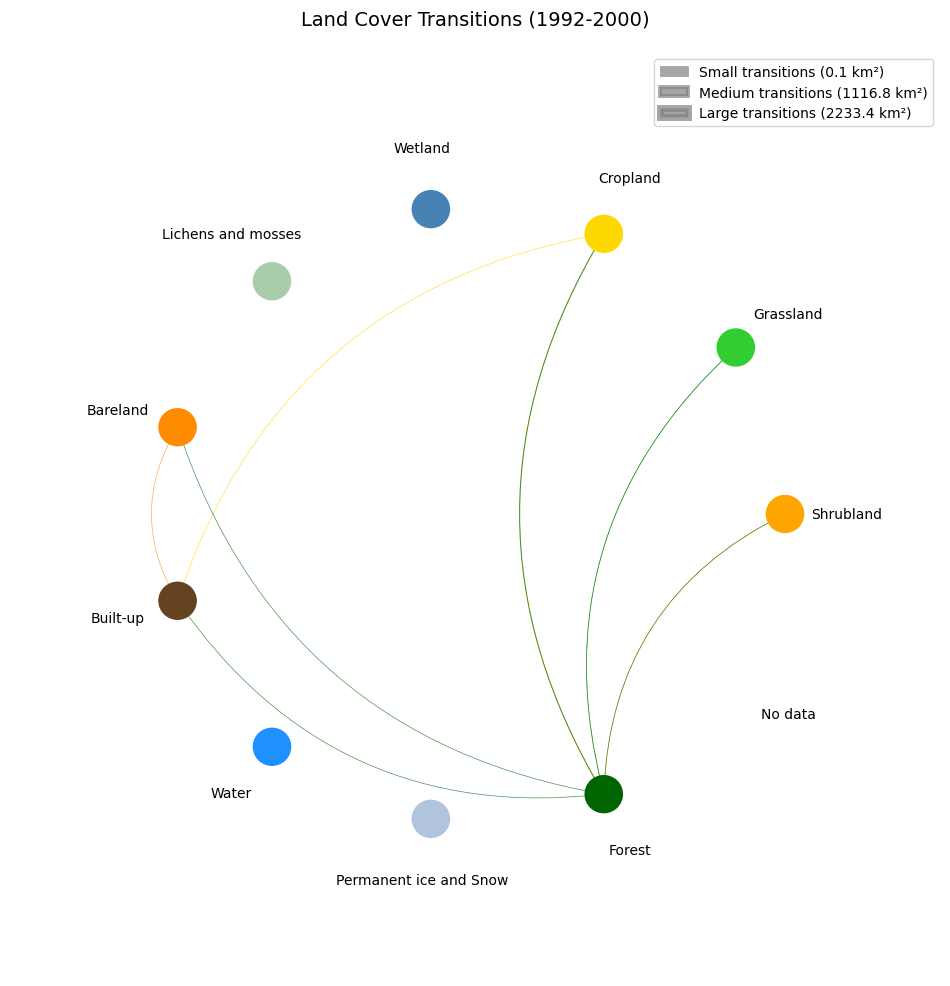

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from matplotlib.patches import ConnectionPatch

# Load your data
file_path = '/Users/ghulamabbaszafari/Downloads/Abbas new/Thesis_project/data/Tevre_clipped _esa_cci/lc_1992_2000/lc_transition_analysis_matrix_1992_2000.csv'
df = pd.read_csv(file_path)

# Class definitions with colors
class_info = {
    5: {'name': 'Shrubland', 'color': '#FFA500'},
    7: {'name': 'Grassland', 'color': '#32cd32'},
    8: {'name': 'Cropland', 'color': '#ffd700'},
    9: {'name': 'Wetland', 'color': '#4682b4'},
    11: {'name': 'Lichens and mosses', 'color': '#a9cda9'},
    12: {'name': 'Bareland', 'color': '#FF8C00'},
    13: {'name': 'Built-up', 'color': '#654321'},
    15: {'name': 'Water', 'color': '#1e90ff'},
    16: {'name': 'Permanent ice and Snow', 'color': '#b0c4de'},
    20: {'name': 'Forest', 'color': '#006400'},
    255: {'name': 'No data', 'color': '#ffffff'}
}

# Prepare matrix for chord diagram
def prepare_matrix(df, class_info):
    matrix = df.pivot(index='From', columns='To', values='Area_km2').fillna(0)
    all_classes = sorted(class_info.keys())
    return matrix.reindex(index=all_classes, columns=all_classes, fill_value=0)

# Create the plot
def create_chord_diagram(matrix, class_info):
    # Setup figure
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Create colormap
    colors = [class_info[code]['color'] for code in sorted(class_info.keys())]
    
    # Normalize values for line width
    max_val = matrix.max().max()
    min_val = matrix[matrix > 0].min().min() if (matrix > 0).any().any() else 1
    norm_val = lambda x: 0.5 + 4.5 * (x - min_val) / (max_val - min_val)
    
    # Plot nodes first
    node_positions = {}
    n_classes = len(class_info)
    radius = 5
    for i, code in enumerate(matrix.index):
        angle = 2 * np.pi * i / n_classes
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        node_positions[code] = (x, y)
        circle = plt.Circle((x, y), 0.3, color=class_info[code]['color'], zorder=3)
        ax.add_patch(circle)
        plt.text(x * 1.2, y * 1.2, class_info[code]['name'], 
                ha='center', va='center', fontsize=10)
    
    # Plot connections
    for i, from_class in enumerate(matrix.index):
        for j, to_class in enumerate(matrix.columns):
            value = matrix.at[from_class, to_class]
            if value > 0:
                x1, y1 = node_positions[from_class]
                x2, y2 = node_positions[to_class]
                
                # Create curved connection
                con = ConnectionPatch(
                    xyA=(x1, y1), 
                    xyB=(x2, y2),
                    coordsA="data", 
                    coordsB="data",
                    arrowstyle="-|>", 
                    mutation_scale=20,
                    lw=norm_val(value),
                    color=class_info[from_class]['color'],
                    alpha=0.7,
                    connectionstyle=f"arc3,rad={0.3 if i < j else -0.3}"
                )
                ax.add_patch(con)
    
    # Set limits
    ax.set_xlim(-radius*1.5, radius*1.5)
    ax.set_ylim(-radius*1.5, radius*1.5)
    ax.axis('off')
    
    # Add title
    plt.title('Land Cover Transitions (1992-2000)', pad=20, fontsize=14)
    
    # Add legend for line widths
    legend_patches = [
        mpatches.Patch(color='gray', alpha=0.7, 
                      linewidth=norm_val(min_val), 
                      label=f'Small transitions ({min_val:.1f} km²)'),
        mpatches.Patch(color='gray', alpha=0.7, 
                      linewidth=norm_val((max_val+min_val)/2), 
                      label=f'Medium transitions ({(max_val+min_val)/2:.1f} km²)'),
        mpatches.Patch(color='gray', alpha=0.7, 
                      linewidth=norm_val(max_val), 
                      label=f'Large transitions ({max_val:.1f} km²)')
    ]
    plt.legend(handles=legend_patches, loc='upper right', fontsize=10)
    
    # Save high-quality version
    plt.savefig('land_cover_transitions.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

# Prepare data and create plot
matrix = prepare_matrix(df, class_info)
create_chord_diagram(matrix, class_info)


In [1]:
import grass.script as gs
import pandas as pd
import os

# -------------------------
# PARAMETERS & CLASS SETUP
# -------------------------

# Update this for your pixel resolution (assumed 300m here)
PIXEL_AREA_KM2 = 0.09  

# Class labels and color mapping
class_labels = {
    5: 'Shrubland',
    7: 'Grassland',
    8: 'Cropland',
    9: 'Wetland',
    11: 'Lichens and mosses',
    12: 'Bareland',
    13: 'Built-up',
    15: 'Water',
    16: 'Permanent ice and Snow',
    20: 'Forest',
    255: 'No data'
}

# Years to process
periods = [("1992", "2000"), ("2000", "2010"), ("2010", "2020")]

# Unique prefix to avoid name conflicts
unique_prefix = "lc_transition_analysis"

# Create output directory
os.makedirs("transition_outputs", exist_ok=True)

# -------------------------
# TRANSITION MATRIX FUNCTION
# -------------------------

def compute_transition_matrix(year_start, year_end):
    raster1 = f"clipped_land_cover_{year_start}"
    raster2 = f"clipped_land_cover_{year_end}"
    transition_map = f"{unique_prefix}_{year_start}_{year_end}"

    print(f"\nProcessing transition: {year_start} → {year_end}")

    # Set region
    gs.run_command("g.region", raster=raster1)

    # Compute transition map
    gs.mapcalc(f"{transition_map} = {raster1} * 1000 + {raster2}", overwrite=True)

    # Get pixel transitions
    stats = gs.read_command("r.stats", flags="cn", input=transition_map, sep=":")
    if not stats.strip():
        print(f"No transitions found between {raster1} and {raster2}")
        return None

    data = []
    for line in stats.strip().splitlines():
        code, count = line.split(":")
        combined = int(code)
        from_class = combined // 1000
        to_class = combined % 1000

        if from_class in class_labels and to_class in class_labels:
            data.append({
                "From": from_class,
                "To": to_class,
                "Count": int(count),
                "Area_km2": int(count) * PIXEL_AREA_KM2,
                "Period": f"{year_start}-{year_end}"
            })

    # Save to CSV
    df = pd.DataFrame(data)
    output_file = f"transition_outputs/{unique_prefix}_matrix_{year_start}_{year_end}.csv"
    df.to_csv(output_file, index=False)
    print(f"✔ Saved CSV: {output_file}")
    return df

# -------------------------
# CREATE TRANSITION MAP (2000–2010)
# -------------------------

def generate_transition_map_visual(year_start="2000", year_end="2010"):
    r1 = f"clipped_land_cover_{year_start}"
    r2 = f"clipped_land_cover_{year_end}"
    map_name = f"{unique_prefix}_map_{year_start}_{year_end}"

    print(f"\nGenerating transition map: {map_name}")
    gs.run_command("g.region", raster=r1)
    gs.mapcalc(f"{map_name} = {r1} * 1000 + {r2}", overwrite=True)

    # Get unique transitions
    stats = gs.read_command("r.stats", flags="n", input=map_name)
    transitions = [int(val) for val in stats.strip().splitlines() if val.strip().isdigit()]

    # Assign unique color to each transition
    color_file = f"/tmp/{map_name}_colors.txt"
    with open(color_file, "w") as f:
        for i, code in enumerate(sorted(transitions)):
            r = (i * 47) % 255
            g = (i * 89) % 255
            b = (i * 131) % 255
            f.write(f"{code} {r}:{g}:{b}\n")

    gs.run_command("r.colors", map=map_name, rules=color_file)
    print(f"✔ Transition map created: {map_name}")

    return map_name

# -------------------------
# EXPORT TRANSITION MAP AS TIFF
# -------------------------

def export_transition_map(year_start="2000", year_end="2010"):
    map_name = f"{unique_prefix}_map_{year_start}_{year_end}"
    output_tif = f"transition_outputs/{map_name}.tif"
    
    print(f"\nExporting transition map to TIFF: {output_tif}")
    
    # Set region to match the transition map
    gs.run_command("g.region", raster=map_name)
    
    # Export as GeoTIFF
    gs.run_command("r.out.gdal", 
                  input=map_name,
                  output=output_tif,
                  format="GTiff",
                  createopt="COMPRESS=LZW",
                  overwrite=True)
    
    print(f"✔ Exported TIFF: {output_tif}")
    return output_tif

# -------------------------
# IMPORT TIFF INTO GRASS GIS
# -------------------------

def import_tiff_to_grass(tiff_path, output_name):
    print(f"\nImporting TIFF back into GRASS: {output_name}")
    
    # Import the TIFF file
    gs.run_command("r.import",
                  input=tiff_path,
                  output=output_name,
                  overwrite=True)
    
    print(f"✔ Imported back to GRASS as: {output_name}")
    return output_name

# -------------------------
# RUN ALL TRANSITIONS
# -------------------------

all_dfs = []
for y1, y2 in periods:
    df = compute_transition_matrix(y1, y2)
    if df is not None:
        all_dfs.append(df)

# Optional: Combine all for a master CSV
if all_dfs:
    combined_df = pd.concat(all_dfs)
    combined_df.to_csv(f"transition_outputs/{unique_prefix}_matrix_ALL.csv", index=False)
    print(f"✔ Combined matrix saved: {unique_prefix}_matrix_ALL.csv")

# -------------------------
# MAP FOR 2000–2010
# -------------------------
transition_map = generate_transition_map_visual("2000", "2010")

# -------------------------
# EXPORT AND IMPORT EXAMPLE
# -------------------------
# Export the transition map to TIFF
tiff_path = export_transition_map("2000", "2010")

# Import the TIFF back into GRASS (optional)
imported_map_name = f"{unique_prefix}_imported_2000_2010"
import_tiff_to_grass(tiff_path, imported_map_name)




Processing transition: 1992 → 2000


✔ Saved CSV: transition_outputs/lc_transition_analysis_matrix_1992_2000.csv

Processing transition: 2000 → 2010


✔ Saved CSV: transition_outputs/lc_transition_analysis_matrix_2000_2010.csv

Processing transition: 2010 → 2020


✔ Saved CSV: transition_outputs/lc_transition_analysis_matrix_2010_2020.csv
✔ Combined matrix saved: lc_transition_analysis_matrix_ALL.csv

Generating transition map: lc_transition_analysis_map_2000_2010



Color table for raster map <lc_transition_analysis_map_2000_2010> set to
'/tmp/lc_transition_analysis_map_2000_2010_colors.txt'


✔ Transition map created: lc_transition_analysis_map_2000_2010

Exporting transition map to TIFF: transition_outputs/lc_transition_analysis_map_2000_2010.tif


Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs/lc_transition_analysis_map_2000_2010.tif> created.


✔ Exported TIFF: transition_outputs/lc_transition_analysis_map_2000_2010.tif

Importing TIFF back into GRASS: lc_transition_analysis_imported_2000_2010
✔ Imported back to GRASS as: lc_transition_analysis_imported_2000_2010


Importing raster map <lc_transition_analysis_imported_2000_2010>...



'lc_transition_analysis_imported_2000_2010'

Found TIFF file at: transition_outputs/lc_transition_analysis_map_2000_2010.tif


/var/folders/mz/wk_rk1fs2m96vphdr62m5bym0000gn/T/grass8-ghulamabbaszafari-19743/ipykernel_19798/237706900.py:70: RuntimeWarning: overflow encountered in scalar multiply
  b = ((from_code + to_code) * 131) % 255 / 255.0


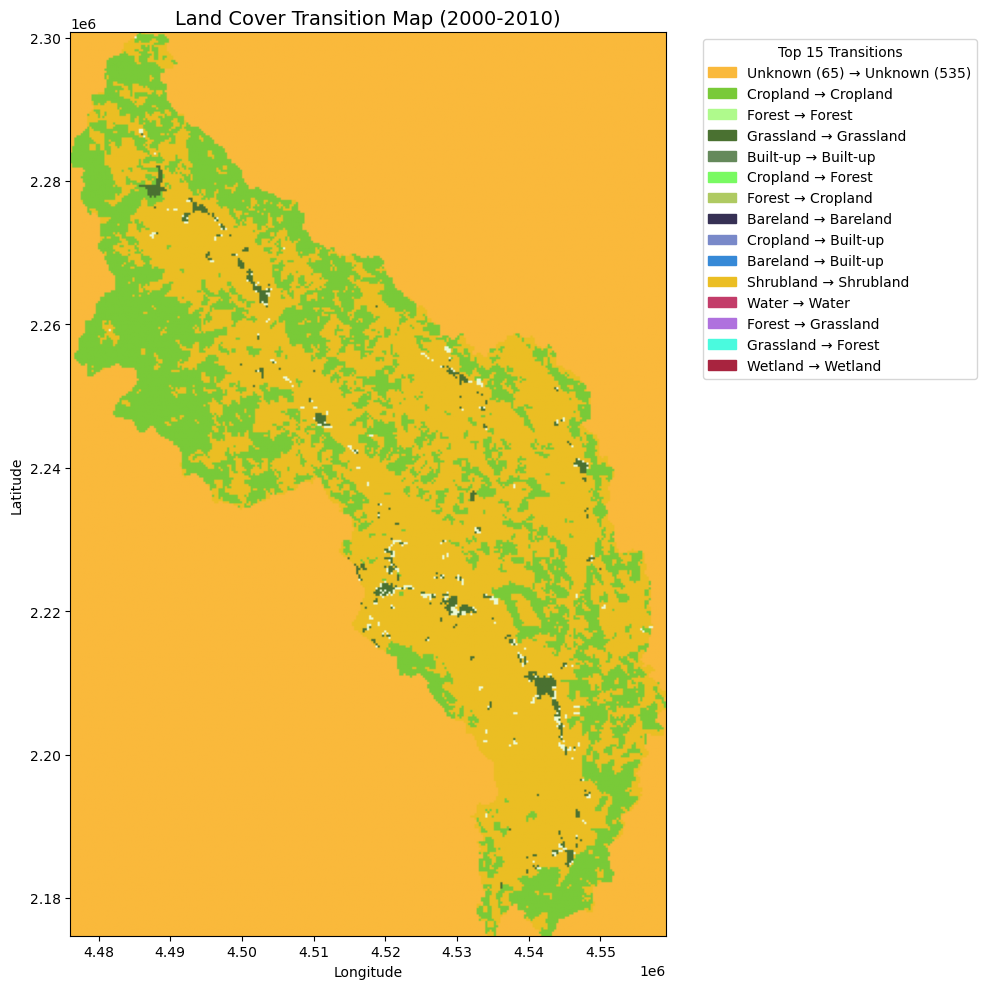

In [3]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# -------------------------
# SETUP CLASS LABELS AND COLORS
# -------------------------

class_labels = {
    5: 'Shrubland',
    7: 'Grassland',
    8: 'Cropland',
    9: 'Wetland',
    11: 'Lichens and mosses',
    12: 'Bareland',
    13: 'Built-up',
    15: 'Water',
    16: 'Permanent ice and Snow',
    20: 'Forest',
    255: 'No data'
}

# -------------------------
# FIND TIFF FILE
# -------------------------

def find_tiff_file():
    # Try common locations
    possible_paths = [
        "transition_outputs/lc_transition_analysis_map_2000_2010.tif",  # Relative path
        os.path.expanduser("~/grassdata/my_location/PERMANENT/cell/transition_outputs/lc_transition_analysis_map_2000_2010.tif"),
        "lc_transition_analysis_map_2000_2010.tif",  # Current directory
        os.path.join(os.getcwd(), "transition_outputs", "lc_transition_analysis_map_2000_2010.tif")
    ]
    
    for path in possible_paths:
        if os.path.exists(path):
            return path
    
    # If not found, try to discover
    for root, dirs, files in os.walk(os.getcwd()):
        if "lc_transition_analysis_map_2000_2010.tif" in files:
            return os.path.join(root, "lc_transition_analysis_map_2000_2010.tif")
    
    raise FileNotFoundError("Could not find the transition TIFF file. Please specify the correct path.")

# -------------------------
# PLOT TRANSITION MAP
# -------------------------

def plot_transition_map(tiff_path):
    try:
        # Open the TIFF file
        with rasterio.open(tiff_path) as src:
            data = src.read(1)
            bounds = src.bounds
            
            # Create transition colors dynamically
            unique_values = np.unique(data)
            transition_colors = {}
            for val in unique_values:
                from_code = val // 1000
                to_code = val % 1000
                # Generate consistent color based on codes
                r = (from_code * 47) % 255 / 255.0
                g = (to_code * 89) % 255 / 255.0
                b = ((from_code + to_code) * 131) % 255 / 255.0
                transition_colors[val] = (r, g, b)
            
            # Create colormap
            cmap = ListedColormap([transition_colors[v] for v in unique_values])
            
            # Create figure
            fig, ax = plt.subplots(figsize=(12, 10))
            
            # Plot the raster
            img = ax.imshow(data, cmap=cmap, 
                          extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
            
            # Create legend for the most common transitions
            unique, counts = np.unique(data, return_counts=True)
            sorted_indices = np.argsort(-counts)
            legend_patches = []
            
            for val in unique[sorted_indices[:15]]:  # Show top 15 transitions
                from_code = val // 1000
                to_code = val % 1000
                from_name = class_labels.get(from_code, f"Unknown ({from_code})")
                to_name = class_labels.get(to_code, f"Unknown ({to_code})")
                
                patch = mpatches.Patch(color=transition_colors[val],
                                     label=f"{from_name} → {to_name}")
                legend_patches.append(patch)
            
            ax.legend(handles=legend_patches, 
                     bbox_to_anchor=(1.05, 1), 
                     loc='upper left',
                     title='Top 15 Transitions')
            
            ax.set_title("Land Cover Transition Map (2000-2010)", fontsize=14)
            ax.set_xlabel("Longitude")
            ax.set_ylabel("Latitude")
            plt.tight_layout()
            plt.show()
            
    except Exception as e:
        print(f"Error plotting map: {str(e)}")
        print("\nPossible solutions:")
        print("1. Check if the TIFF file exists at the specified path")
        print("2. Run the export code first to generate the TIFF file")
        print("3. Specify the correct path to your TIFF file")
        print(f"\nCurrent working directory: {os.getcwd()}")
        print(f"Files in transition_outputs directory: {os.listdir('transition_outputs') if os.path.exists('transition_outputs') else 'Directory not found'}")

# -------------------------
# RUN THE PLOT FUNCTION
# -------------------------

try:
    # Try to automatically find the file
    tiff_path = find_tiff_file()
    print(f"Found TIFF file at: {tiff_path}")
except FileNotFoundError as e:
    print(str(e))
    # Manual fallback - replace with your actual path if needed
    tiff_path = input("Please enter the full path to your transition TIFF file: ")

# Plot the transition map
plot_transition_map(tiff_path)

Found transition file at: transition_outputs/lc_transition_analysis_map_2000_2010.tif


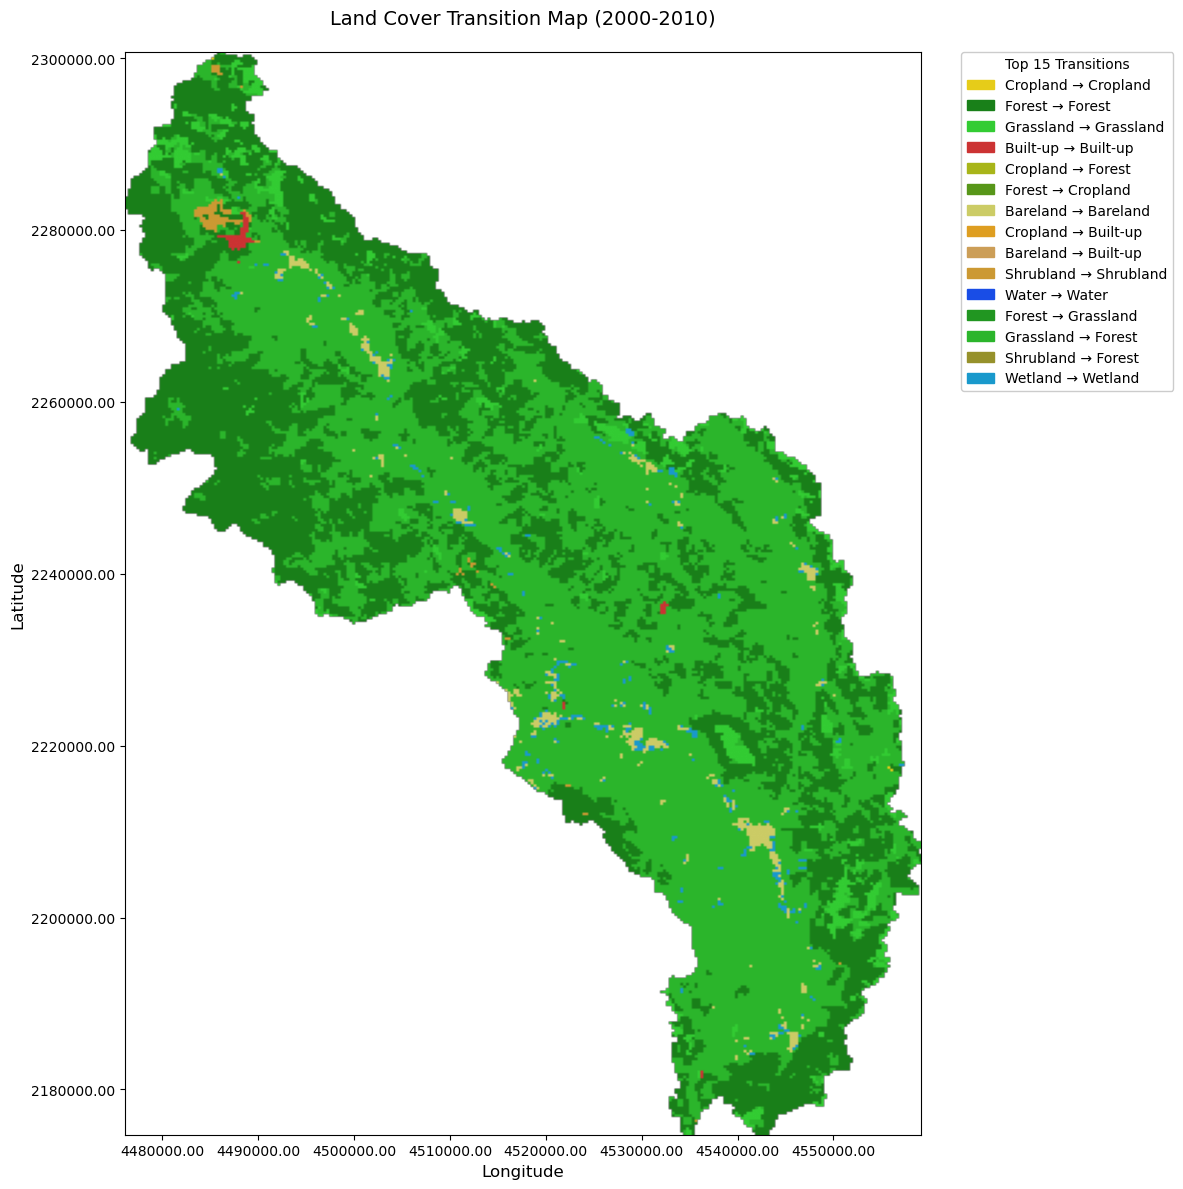

In [10]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib.ticker import FormatStrFormatter

# -------------------------
# PROPER CLASS LABELS AND COLORS
# -------------------------

CLASS_LABELS = {
    5: 'Shrubland',
    7: 'Grassland',
    8: 'Cropland',
    9: 'Wetland',
    11: 'Lichens and mosses',
    12: 'Bareland',
    13: 'Built-up',
    15: 'Water',
    16: 'Permanent ice and Snow',
    20: 'Forest',
    255: 'No data'
}

# Base colors for original classes (for consistent transition colors)
BASE_COLORS = {
    5: (0.8, 0.6, 0.2),    # Shrubland (brownish)
    7: (0.2, 0.8, 0.2),    # Grassland (green)
    8: (0.9, 0.8, 0.1),    # Cropland (yellow)
    9: (0.1, 0.6, 0.8),    # Wetland (blue-green)
    11: (0.6, 0.2, 0.8),   # Lichens/mosses (purple)
    12: (0.8, 0.8, 0.4),   # Bareland (tan)
    13: (0.8, 0.2, 0.2),   # Built-up (red)
    15: (0.1, 0.3, 0.9),   # Water (blue)
    16: (0.9, 0.9, 0.9),   # Ice/Snow (white)
    20: (0.1, 0.5, 0.1),   # Forest (dark green)
    255: (0.5, 0.5, 0.5)   # No data (gray)
}

def get_transition_color(from_code, to_code):
    """Get consistent color for a transition"""
    from_color = BASE_COLORS.get(from_code, (0.5, 0.5, 0.5))
    to_color = BASE_COLORS.get(to_code, (0.5, 0.5, 0.5))
    # Blend colors (70% from, 30% to)
    return (
        from_color[0]*0.7 + to_color[0]*0.3,
        from_color[1]*0.7 + to_color[1]*0.3,
        from_color[2]*0.7 + to_color[2]*0.3
    )

# -------------------------
# IMPROVED FILE LOCATION HANDLING
# -------------------------

def find_transition_file():
    """Search for the transition file in likely locations"""
    # Try default output directory first
    default_path = os.path.join("transition_outputs", "lc_transition_analysis_map_2000_2010.tif")
    if os.path.exists(default_path):
        return default_path
    
    # Check GRASS GIS default location
    grass_path = os.path.join(os.path.expanduser("~"), "grassdata", "my_location", "PERMANENT", 
                            "cell", "transition_outputs", "lc_transition_analysis_map_2000_2010.tif")
    if os.path.exists(grass_path):
        return grass_path
    
    # Search recursively from current directory
    for root, _, files in os.walk(os.getcwd()):
        for file in files:
            if file.lower() in ["lc_transition_analysis_map_2000_2010.tif", 
                              "1_c_transition_analysis_map_2000_2010.tif"]:
                return os.path.join(root, file)
    
    return None

# -------------------------
# IMPROVED PLOT FUNCTION
# -------------------------

def plot_transition_map(tiff_path):
    try:
        with rasterio.open(tiff_path) as src:
            data = src.read(1)
            bounds = src.bounds
            
            # Create figure with better layout
            fig, ax = plt.subplots(figsize=(12, 12))
            
            # Generate colors for all unique transitions
            unique_values = np.unique(data[data != src.nodata])
            transition_info = {}
            
            for val in unique_values:
                from_code = val // 1000
                to_code = val % 1000
                from_name = CLASS_LABELS.get(from_code, f"Class {from_code}")
                to_name = CLASS_LABELS.get(to_code, f"Class {to_code}")
                
                transition_info[val] = {
                    'from': from_code,
                    'to': to_code,
                    'name': f"{from_name} → {to_name}",
                    'color': get_transition_color(from_code, to_code)
                }
            
            # Create colormap
            cmap = ListedColormap([transition_info[v]['color'] for v in unique_values])
            
            # Plot with proper nodata handling
            plot_data = np.ma.masked_equal(data, src.nodata)
            img = ax.imshow(plot_data, cmap=cmap,
                          extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
                          aspect='auto')
            
            # Format axes
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            ax.set_xlabel("Longitude", fontsize=12)
            ax.set_ylabel("Latitude", fontsize=12)
            ax.set_title("Land Cover Transition Map (2000-2010)", fontsize=14, pad=20)
            
            # Create legend - show top 15 most frequent transitions
            counts = {v: np.sum(data == v) for v in unique_values}
            sorted_transitions = sorted(unique_values, key=lambda x: -counts[x])
            
            legend_patches = []
            for val in sorted_transitions[:15]:
                info = transition_info[val]
                patch = mpatches.Patch(color=info['color'], label=info['name'])
                legend_patches.append(patch)
            
            # Place legend outside with scrollbar if needed
            ax.legend(handles=legend_patches,
                     title='Top 15 Transitions',
                     bbox_to_anchor=(1.05, 1),
                     loc='upper left',
                     borderaxespad=0.,
                     framealpha=1)
            
            plt.tight_layout()
            plt.show()
            
    except Exception as e:
        print(f"Error: {str(e)}")
        if 'No such file' in str(e):
            print("\nPlease verify:")
            print(f"1. File exists at: {os.path.abspath(tiff_path)}")
            print(f"2. Current directory: {os.getcwd()}")
            dir_path = os.path.dirname(tiff_path)
            if os.path.exists(dir_path):
                print(f"3. Directory contents: {os.listdir(dir_path)}")
            else:
                print("3. Directory not found")

# -------------------------
# MAIN EXECUTION
# -------------------------

if __name__ == "__main__":
    # Try to automatically find the file
    tiff_path = find_transition_file()
    
    if tiff_path:
        print(f"Found transition file at: {tiff_path}")
        plot_transition_map(tiff_path)
    else:
        print("Could not automatically find the transition file.")
        print("Please provide the full path to your transition TIFF file.")
        print("Common locations to check:")
        print(f"1. {os.path.join('transition_outputs', 'lc_transition_analysis_map_2000_2010.tif')}")
        print(f"2. {os.path.join(os.path.expanduser('~'), 'grassdata', 'my_location', 'PERMANENT', 'cell', 'transition_outputs', 'lc_transition_analysis_map_2000_2010.tif')}")
        
        # Manual input fallback
        tiff_path = input("\nEnter full path to transition file: ").strip()
        if os.path.exists(tiff_path):
            plot_transition_map(tiff_path)
        else:
            print("File not found. Please verify the path and try again.")


            

In [4]:
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

# -------------------------
# PARAMETERS
# -------------------------
# Updated to point to your GRASS location
input_tif = "grassdata/my_location/PERMANENT/cell/transition_outputs/lc_transition_analysis_map_2000_2010.tif"
output_plot = "transition_plot_2000_2010_final.png"
title = "Land Cover Transition 2000-2010"

# Class definitions
class_labels = {
    5: 'Shrubland',
    7: 'Grassland',
    8: 'Cropland',
    9: 'Wetland',
    11: 'Lichens and mosses',
    12: 'Bareland',
    13: 'Built-up',
    15: 'Water',
    16: 'Permanent ice and Snow',
    20: 'Forest',
    255: 'No data'
}

# Color specifications
color_map = {
    'Shrubland': '#8b4513',
    'Grassland': '#32cd32',
    'Cropland': '#ffd700',
    'Wetland': '#4682b4',
    'Lichens and mosses': '#a9cda9',
    'Bareland': '#c2b280',
    'Built-up': '#808080',
    'Water': '#1e90ff',
    'Permanent ice and Snow': '#b0c4de',
    'Forest': '#006400',
    'No data': '#ffffff'
}

# -------------------------
# FILE LOCATION HANDLING
# -------------------------
def find_transition_file():
    """Locate the transition file in GRASS database"""
    # Try the exact path first
    if os.path.exists(input_tif):
        return input_tif
    
    # Alternative search locations
    search_paths = [
        input_tif,
        os.path.join("grassdata", "my_location", "PERMANENT", "cell", "lc_transition_analysis_map_2000_2010.tif"),
        os.path.join("transition_outputs", "lc_transition_analysis_map_2000_2010.tif"),
        "lc_transition_analysis_map_2000_2010.tif"
    ]
    
    for path in search_paths:
        if os.path.exists(path):
            return path
    
    raise FileNotFoundError(f"Could not find transition file. Tried: {search_paths}")

# -------------------------
# COLOR MAPPING
# -------------------------
def get_transition_colors():
    """Create color mapping with exact colors"""
    class_rgb = {cls: mcolors.hex2color(hex) for cls, hex in color_map.items()}
    
    transition_colors = {}
    for from_code, from_class in class_labels.items():
        for to_code, to_class in class_labels.items():
            code = from_code * 1000 + to_code
            # 30%/70% blend
            blended = (
                0.3 * class_rgb[from_class][0] + 0.7 * class_rgb[to_class][0],
                0.3 * class_rgb[from_class][1] + 0.7 * class_rgb[to_class][1],
                0.3 * class_rgb[from_class][2] + 0.7 * class_rgb[to_class][2]
            )
            transition_colors[code] = blended
    
    # Force exact colors for no-change transitions
    for code, label in class_labels.items():
        transition_colors[code * 1000 + code] = class_rgb[label]
    
    return transition_colors

# -------------------------
# PLOT CREATION
# -------------------------
def create_transition_plot():
    # Locate the file
    tif_path = find_transition_file()
    print(f"Found transition file at: {tif_path}")
    
    # Load the transition map
    with rasterio.open(tif_path) as src:
        data = src.read(1)
        nodata = src.nodata
    
    # Process data
    data = data.astype(float)
    data[data == nodata] = np.nan
    
    # Get unique transition codes
    unique_codes = np.unique(data[~np.isnan(data)]).astype(int)
    
    # Create color mapping
    all_colors = get_transition_colors()
    present_colors = {code: all_colors[code] for code in unique_codes if code in all_colors}
    
    # Verify critical colors
    print("\nColor Verification:")
    print(f"Shrubland (5005): RGB {[int(x*255) for x in all_colors[5005]]}")
    print(f"Built-up (13013): RGB {[int(x*255) for x in all_colors[13013]]}")
    
    # Create plot
    fig, ax = plt.subplots(figsize=(18, 12))
    
    # Create colormap and normalization
    sorted_codes = sorted(present_colors.keys())
    cmap = ListedColormap([present_colors[code] for code in sorted_codes])
    norm = mcolors.BoundaryNorm(sorted_codes + [max(sorted_codes)+1], cmap.N)
    
    # Plot the raster
    im = ax.imshow(data, cmap=cmap, norm=norm)
    
    # Add title
    plt.title(title, fontsize=16, pad=20)
    
    # Create organized legend
    legend_elements = []
    for code in sorted_codes:
        from_class = class_labels.get(code // 1000, 'Unknown')
        to_class = class_labels.get(code % 1000, 'Unknown')
        label = f"{code}: {from_class} → {to_class}"
        legend_elements.append(
            Patch(facecolor=present_colors[code], edgecolor='black', 
                 linewidth=0.5, label=label)
        )
    
    # Add legend
    legend = ax.legend(
        handles=legend_elements,
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0.,
        fontsize=8,
        title="Transition Codes",
        framealpha=1,
        ncol=2,
        title_fontsize='12'
    )
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 0.7, 1])
    
    # Save output
    plt.savefig(output_plot, dpi=300, bbox_inches='tight')
    print(f"\n✔ Saved transition plot: {output_plot}")
    plt.close()

if __name__ == "__main__":
    create_transition_plot()

Found transition file at: transition_outputs/lc_transition_analysis_map_2000_2010.tif

Color Verification:
Shrubland (5005): RGB [139, 69, 19]
Built-up (13013): RGB [128, 128, 128]

✔ Saved transition plot: transition_plot_2000_2010_final.png


Found transition file at: transition_outputs/lc_transition_analysis_map_2000_2010.tif

Color Verification:
Shrubland (5005): RGB [139, 69, 19]
Built-up (13013): RGB [128, 128, 128]

✔ Saved transition plot: transition_plot_2000_2010_final.png


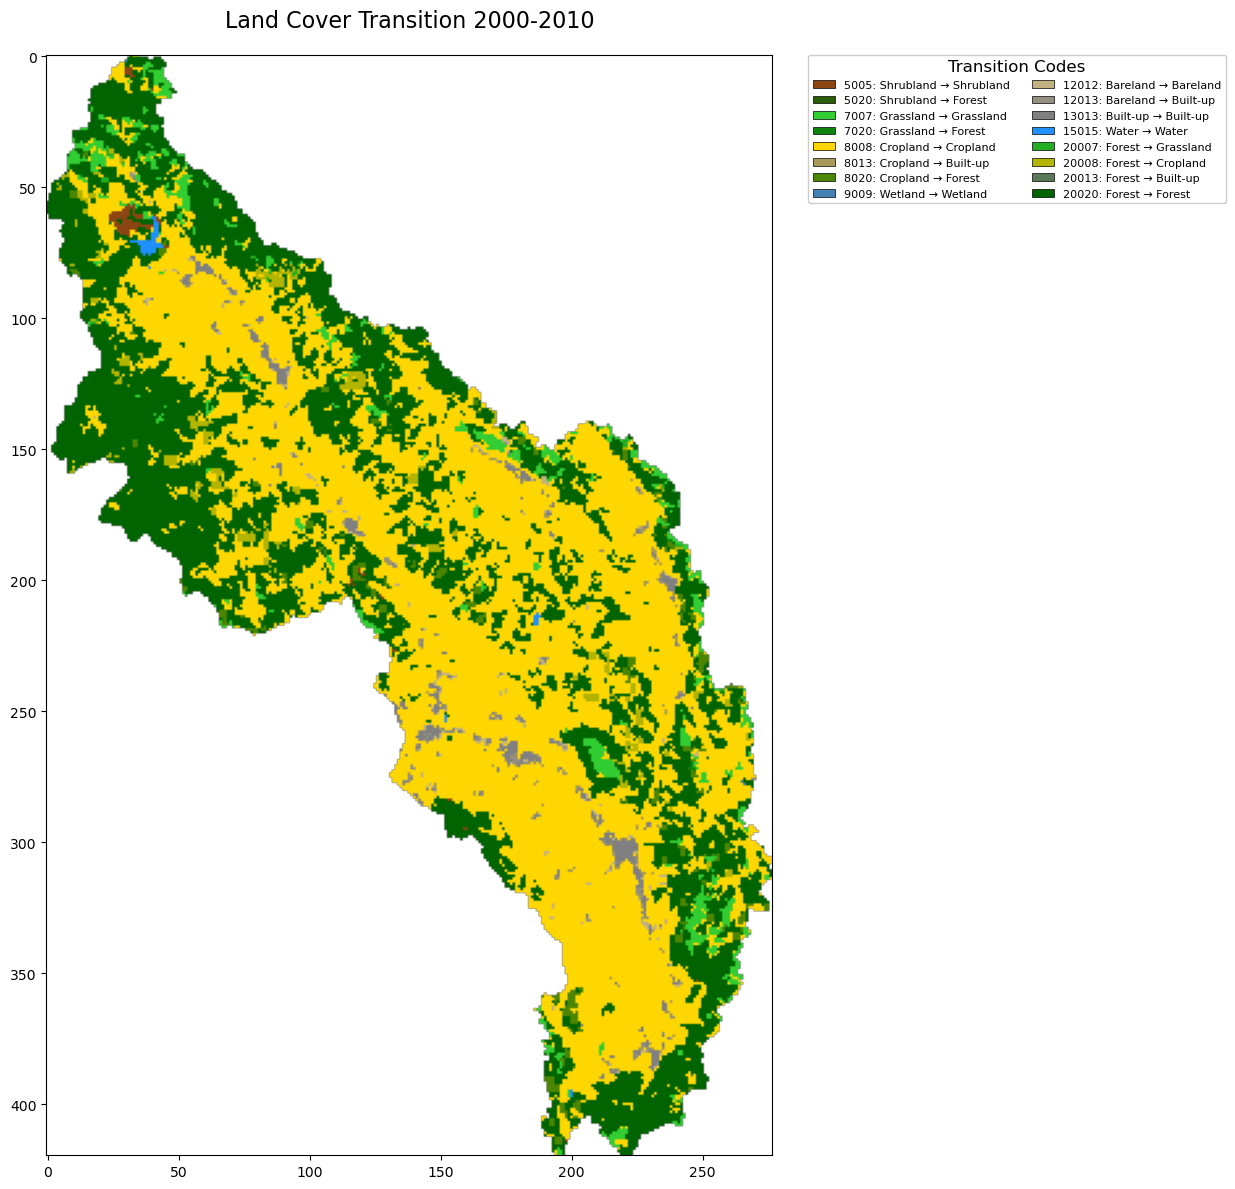

In [5]:
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
from IPython.display import display  # For Jupyter display

# -------------------------
# PARAMETERS
# -------------------------
# Updated to point to your GRASS location
input_tif = "grassdata/my_location/PERMANENT/cell/transition_outputs/lc_transition_analysis_map_2000_2010.tif"
output_plot = "transition_plot_2000_2010_final.png"
title = "Land Cover Transition 2000-2010"

# Class definitions
class_labels = {
    5: 'Shrubland',
    7: 'Grassland',
    8: 'Cropland',
    9: 'Wetland',
    11: 'Lichens and mosses',
    12: 'Bareland',
    13: 'Built-up',
    15: 'Water',
    16: 'Permanent ice and Snow',
    20: 'Forest',
    255: 'No data'
}

# Color specifications
color_map = {
    'Shrubland': '#8b4513',
    'Grassland': '#32cd32',
    'Cropland': '#ffd700',
    'Wetland': '#4682b4',
    'Lichens and mosses': '#a9cda9',
    'Bareland': '#c2b280',
    'Built-up': '#808080',
    'Water': '#1e90ff',
    'Permanent ice and Snow': '#b0c4de',
    'Forest': '#006400',
    'No data': '#ffffff'
}

# -------------------------
# FILE LOCATION HANDLING
# -------------------------
def find_transition_file():
    """Locate the transition file in GRASS database"""
    # Try the exact path first
    if os.path.exists(input_tif):
        return input_tif
    
    # Alternative search locations
    search_paths = [
        input_tif,
        os.path.join("grassdata", "my_location", "PERMANENT", "cell", "lc_transition_analysis_map_2000_2010.tif"),
        os.path.join("transition_outputs", "lc_transition_analysis_map_2000_2010.tif"),
        "lc_transition_analysis_map_2000_2010.tif"
    ]
    
    for path in search_paths:
        if os.path.exists(path):
            return path
    
    raise FileNotFoundError(f"Could not find transition file. Tried: {search_paths}")

# -------------------------
# COLOR MAPPING
# -------------------------
def get_transition_colors():
    """Create color mapping with exact colors"""
    class_rgb = {cls: mcolors.hex2color(hex) for cls, hex in color_map.items()}
    
    transition_colors = {}
    for from_code, from_class in class_labels.items():
        for to_code, to_class in class_labels.items():
            code = from_code * 1000 + to_code
            # 30%/70% blend
            blended = (
                0.3 * class_rgb[from_class][0] + 0.7 * class_rgb[to_class][0],
                0.3 * class_rgb[from_class][1] + 0.7 * class_rgb[to_class][1],
                0.3 * class_rgb[from_class][2] + 0.7 * class_rgb[to_class][2]
            )
            transition_colors[code] = blended
    
    # Force exact colors for no-change transitions
    for code, label in class_labels.items():
        transition_colors[code * 1000 + code] = class_rgb[label]
    
    return transition_colors

# -------------------------
# PLOT CREATION & DISPLAY
# -------------------------
def create_transition_plot(display_in_notebook=True):
    """Create and optionally display the transition plot"""
    # Locate the file
    tif_path = find_transition_file()
    print(f"Found transition file at: {tif_path}")
    
    # Load the transition map
    with rasterio.open(tif_path) as src:
        data = src.read(1)
        nodata = src.nodata
    
    # Process data
    data = data.astype(float)
    data[data == nodata] = np.nan
    
    # Get unique transition codes
    unique_codes = np.unique(data[~np.isnan(data)]).astype(int)
    
    # Create color mapping
    all_colors = get_transition_colors()
    present_colors = {code: all_colors[code] for code in unique_codes if code in all_colors}
    
    # Verify critical colors
    print("\nColor Verification:")
    print(f"Shrubland (5005): RGB {[int(x*255) for x in all_colors[5005]]}")
    print(f"Built-up (13013): RGB {[int(x*255) for x in all_colors[13013]]}")
    
    # Create plot
    fig, ax = plt.subplots(figsize=(18, 12))
    
    # Create colormap and normalization
    sorted_codes = sorted(present_colors.keys())
    cmap = ListedColormap([present_colors[code] for code in sorted_codes])
    norm = mcolors.BoundaryNorm(sorted_codes + [max(sorted_codes)+1], cmap.N)
    
    # Plot the raster
    im = ax.imshow(data, cmap=cmap, norm=norm)
    
    # Add title
    plt.title(title, fontsize=16, pad=20)
    
    # Create organized legend
    legend_elements = []
    for code in sorted_codes:
        from_class = class_labels.get(code // 1000, 'Unknown')
        to_class = class_labels.get(code % 1000, 'Unknown')
        label = f"{code}: {from_class} → {to_class}"
        legend_elements.append(
            Patch(facecolor=present_colors[code], edgecolor='black', 
                 linewidth=0.5, label=label)
        )
    
    # Add legend
    legend = ax.legend(
        handles=legend_elements,
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0.,
        fontsize=8,
        title="Transition Codes",
        framealpha=1,
        ncol=2,
        title_fontsize='12'
    )
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 0.7, 1])
    
    # Save output
    plt.savefig(output_plot, dpi=300, bbox_inches='tight')
    print(f"\n✔ Saved transition plot: {output_plot}")
    
    # Display in notebook if requested
    if display_in_notebook:
        display(fig)
    else:
        plt.show()
    
    plt.close()

# -------------------------
# EXECUTE
# -------------------------
if __name__ == "__main__":
    # When running as script
    create_transition_plot(display_in_notebook=False)
else:
    # When running in Jupyter
    create_transition_plot(display_in_notebook=True)
    

Found transition file at: transition_outputs/lc_transition_analysis_map_2000_2010.tif

TRANSITION MATRIX WITH AREA CALCULATIONS
----------------------------------------


Code,From,To,Pixel Count,Area (km²)
5005,Shrubland,Shrubland,129,0.12
5020,Shrubland,Forest,3,0.00
7007,Grassland,Grassland,"1,582",1.42
7020,Grassland,Forest,17,0.02
8008,Cropland,Cropland,"25,329",22.80
8013,Cropland,Built-up,191,0.17
8020,Cropland,Forest,656,0.59
9009,Wetland,Wetland,3,0.00
12012,Bareland,Bareland,231,0.21
12013,Bareland,Built-up,147,0.13




TRANSITION MAP VISUALIZATION
---------------------------


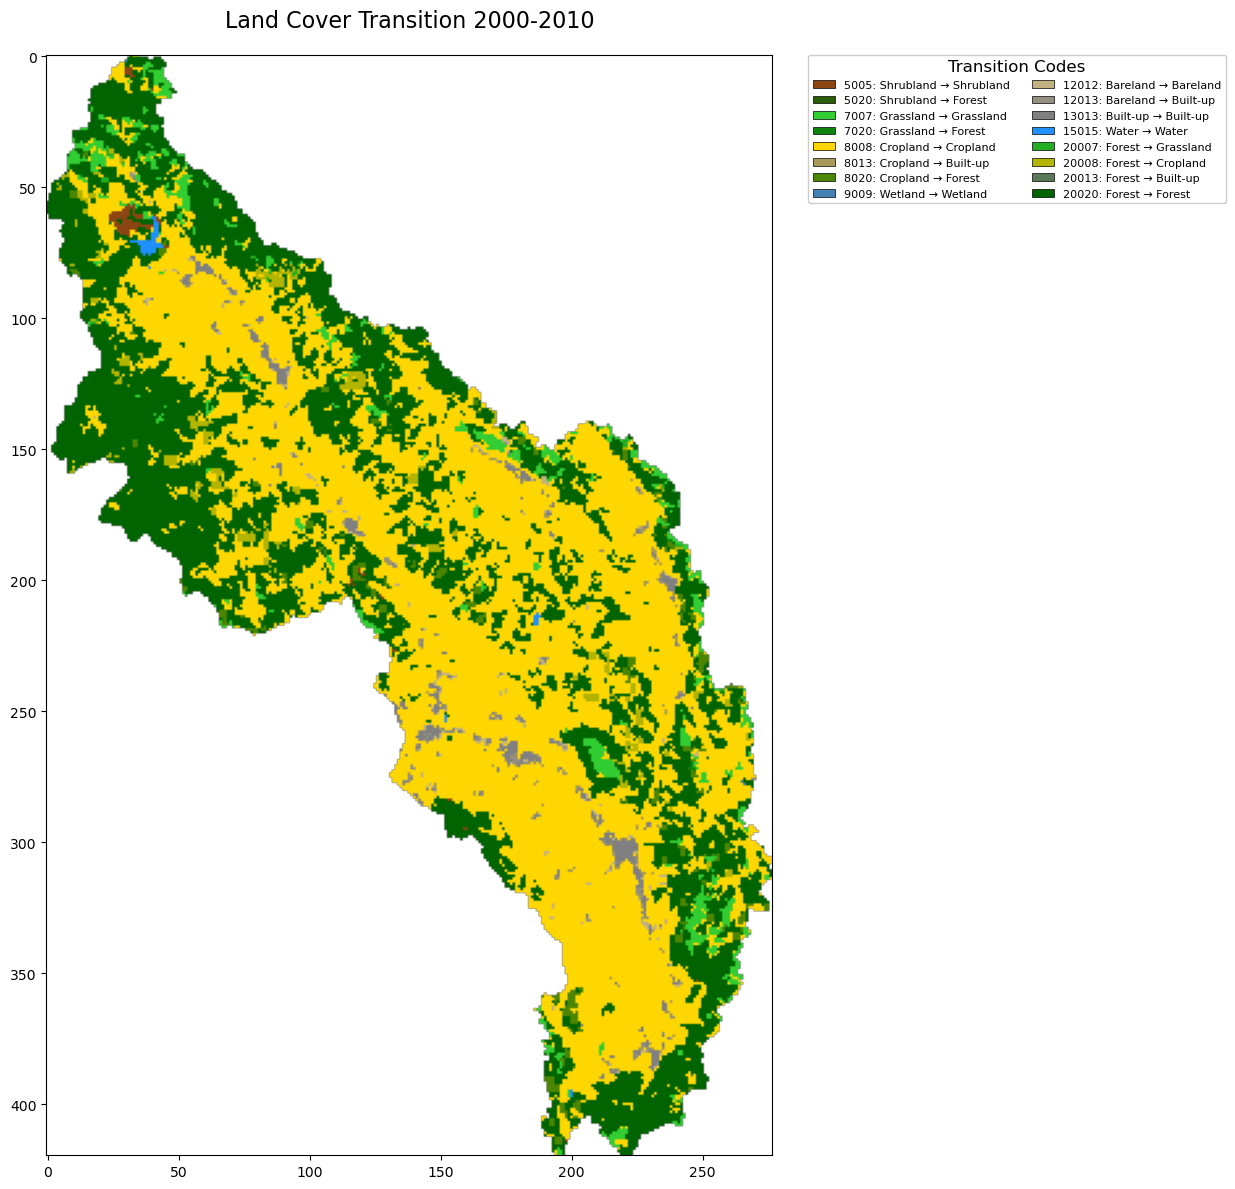


✔ Saved transition plot: transition_plot_2000_2010_final.png


<Figure size 640x480 with 0 Axes>

In [6]:
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
from IPython.display import display, HTML

# -------------------------
# PARAMETERS
# -------------------------
input_tif = "grassdata/my_location/PERMANENT/cell/transition_outputs/lc_transition_analysis_map_2000_2010.tif"
output_plot = "transition_plot_2000_2010_final.png"
title = "Land Cover Transition 2000-2010"
pixel_area_km2 = 0.0009  # 30m x 30m = 900 m² = 0.0009 km²

# Class definitions
class_labels = {
    5: 'Shrubland',
    7: 'Grassland',
    8: 'Cropland',
    9: 'Wetland',
    11: 'Lichens and mosses',
    12: 'Bareland',
    13: 'Built-up',
    15: 'Water',
    16: 'Permanent ice and Snow',
    20: 'Forest',
    255: 'No data'
}

# Color specifications
color_map = {
    'Shrubland': '#8b4513',
    'Grassland': '#32cd32',
    'Cropland': '#ffd700',
    'Wetland': '#4682b4',
    'Lichens and mosses': '#a9cda9',
    'Bareland': '#c2b280',
    'Built-up': '#808080',
    'Water': '#1e90ff',
    'Permanent ice and Snow': '#b0c4de',
    'Forest': '#006400',
    'No data': '#ffffff'
}

# -------------------------
# FILE LOCATION HANDLING
# -------------------------
def find_transition_file():
    """Locate the transition file in GRASS database"""
    search_paths = [
        input_tif,
        os.path.join("grassdata", "my_location", "PERMANENT", "cell", "lc_transition_analysis_map_2000_2010.tif"),
        os.path.join("transition_outputs", "lc_transition_analysis_map_2000_2010.tif"),
        "lc_transition_analysis_map_2000_2010.tif"
    ]
    
    for path in search_paths:
        if os.path.exists(path):
            return path
    
    raise FileNotFoundError(f"Could not find transition file. Tried: {search_paths}")

# -------------------------
# COLOR MAPPING
# -------------------------
def get_transition_colors():
    """Create color mapping with exact colors"""
    class_rgb = {cls: mcolors.hex2color(hex) for cls, hex in color_map.items()}
    
    transition_colors = {}
    for from_code, from_class in class_labels.items():
        for to_code, to_class in class_labels.items():
            code = from_code * 1000 + to_code
            # 30%/70% blend
            blended = (
                0.3 * class_rgb[from_class][0] + 0.7 * class_rgb[to_class][0],
                0.3 * class_rgb[from_class][1] + 0.7 * class_rgb[to_class][1],
                0.3 * class_rgb[from_class][2] + 0.7 * class_rgb[to_class][2]
            )
            transition_colors[code] = blended
    
    # Force exact colors for no-change transitions
    for code, label in class_labels.items():
        transition_colors[code * 1000 + code] = class_rgb[label]
    
    return transition_colors

# -------------------------
# TRANSITION MATRIX CALCULATION
# -------------------------
def calculate_transition_matrix(data):
    """Calculate transition matrix from raster data"""
    unique_codes = np.unique(data[~np.isnan(data)]).astype(int)
    transitions = []
    
    for code in unique_codes:
        from_class = code // 1000
        to_class = code % 1000
        count = np.sum(data == code)
        
        if from_class in class_labels and to_class in class_labels:
            transitions.append({
                'Code': code,
                'From': class_labels[from_class],
                'To': class_labels[to_class],
                'Pixel Count': count,
                'Area (km²)': count * pixel_area_km2
            })
    
    return pd.DataFrame(transitions)

# -------------------------
# PLOT CREATION
# -------------------------
def create_transition_plot(data):
    """Create and display the transition plot"""
    # Get unique transition codes
    unique_codes = np.unique(data[~np.isnan(data)]).astype(int)
    
    # Create color mapping
    all_colors = get_transition_colors()
    present_colors = {code: all_colors[code] for code in unique_codes if code in all_colors}
    
    # Create plot
    fig, ax = plt.subplots(figsize=(18, 12))
    
    # Create colormap and normalization
    sorted_codes = sorted(present_colors.keys())
    cmap = ListedColormap([present_colors[code] for code in sorted_codes])
    norm = mcolors.BoundaryNorm(sorted_codes + [max(sorted_codes)+1], cmap.N)
    
    # Plot the raster
    im = ax.imshow(data, cmap=cmap, norm=norm)
    
    # Add title
    plt.title(title, fontsize=16, pad=20)
    
    # Create organized legend
    legend_elements = []
    for code in sorted_codes:
        from_class = class_labels.get(code // 1000, 'Unknown')
        to_class = class_labels.get(code % 1000, 'Unknown')
        label = f"{code}: {from_class} → {to_class}"
        legend_elements.append(
            Patch(facecolor=present_colors[code], edgecolor='black', 
                 linewidth=0.5, label=label)
        )
    
    # Add legend
    legend = ax.legend(
        handles=legend_elements,
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0.,
        fontsize=8,
        title="Transition Codes",
        framealpha=1,
        ncol=2,
        title_fontsize='12'
    )
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 0.7, 1])
    plt.show()

# -------------------------
# MAIN FUNCTION
# -------------------------
def analyze_transitions():
    """Main function to analyze and display transitions"""
    # Locate and load the transition file
    tif_path = find_transition_file()
    print(f"Found transition file at: {tif_path}")
    
    with rasterio.open(tif_path) as src:
        data = src.read(1)
        nodata = src.nodata
    
    # Process data
    data = data.astype(float)
    data[data == nodata] = np.nan
    
    # Calculate transition matrix
    transition_df = calculate_transition_matrix(data)
    
    # Display results in Jupyter
    print("\nTRANSITION MATRIX WITH AREA CALCULATIONS")
    print("----------------------------------------")
    
    # Format the DataFrame for nice display
    display_df = transition_df.copy()
    display_df['Area (km²)'] = display_df['Area (km²)'].apply(lambda x: f"{x:,.2f}")
    display_df['Pixel Count'] = display_df['Pixel Count'].apply(lambda x: f"{x:,}")
    
    # Display the transition matrix
    display(HTML(display_df.to_html(index=False)))
    
    # Create and show the plot
    print("\n\nTRANSITION MAP VISUALIZATION")
    print("---------------------------")
    create_transition_plot(data)
    
    # Save the plot
    plt.savefig(output_plot, dpi=300, bbox_inches='tight')
    print(f"\n✔ Saved transition plot: {output_plot}")

# -------------------------
# EXECUTE
# -------------------------
if __name__ == "__main__":
    analyze_transitions()
else:
    analyze_transitions()

    

In [1]:
import grass.script as gs
import pandas as pd
import os
import datetime

# -------------------------
# PARAMETERS & CLASS SETUP
# -------------------------

# Pixel resolution (300m)
PIXEL_AREA_KM2 = 0.09  # 300m x 300m = 0.09 km²

# Class labels and color mapping
class_labels = {
    5: 'Shrubland',
    7: 'Grassland',
    8: 'Cropland',
    9: 'Wetland',
    11: 'Lichens and mosses',
    12: 'Bareland',
    13: 'Built-up',
    15: 'Water',
    16: 'Permanent ice and Snow',
    20: 'Forest',
    255: 'No data'
}

# All available years in the dataset (updated to include all annual data)
all_years = [
    1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,  # Annual from 1992
    2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,  # Continued annual
    2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,  # Continued annual
    2020, 2021, 2022  # Recent years
]

# Generate all consecutive year pairs
all_periods = [(str(all_years[i]), str(all_years[i+1])) 
              for i in range(len(all_years)-1)]

# Unique prefix for outputs
unique_prefix = "lc_annual_transition_analysis"

# Create output directory with timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
output_dir = f"transition_outputs_annual_{timestamp}"
os.makedirs(output_dir, exist_ok=True)

# -------------------------
# TRANSITION MATRIX FUNCTION
# -------------------------

def compute_transition_matrix(year_start, year_end):
    raster1 = f"clipped_land_cover_{year_start}"
    raster2 = f"clipped_land_cover_{year_end}"
    transition_map = f"{unique_prefix}_{year_start}_{year_end}"

    print(f"\nProcessing annual transition: {year_start} → {year_end}")

    # Verify input rasters exist
    if not gs.find_file(raster1)['file'] or not gs.find_file(raster2)['file']:
        print(f"Warning: Missing data for {year_start} or {year_end}")
        return None

    # Set computational region
    gs.run_command("g.region", raster=raster1)

    # Create transition map (from*1000 + to)
    gs.mapcalc(f"{transition_map} = {raster1} * 1000 + {raster2}", overwrite=True)

    # Get transition statistics
    stats = gs.read_command("r.stats", flags="cn", input=transition_map, sep=":")
    if not stats.strip():
        print(f"No transitions found between {raster1} and {raster2}")
        return None

    data = []
    for line in stats.strip().splitlines():
        code, count = line.split(":")
        from_class = int(code) // 1000
        to_class = int(code) % 1000

        if from_class in class_labels and to_class in class_labels:
            data.append({
                "From": from_class,
                "To": to_class,
                "Count": int(count),
                "Area_km2": int(count) * PIXEL_AREA_KM2,
                "Period": f"{year_start}-{year_end}",
                "From_Class": class_labels[from_class],
                "To_Class": class_labels[to_class],
                "Year": int(year_start)  # Add year for temporal analysis
            })

    # Save to CSV
    df = pd.DataFrame(data)
    output_file = f"{output_dir}/{unique_prefix}_matrix_{year_start}_{year_end}.csv"
    df.to_csv(output_file, index=False)
    print(f"✔ Saved CSV: {output_file}")
    return df

# -------------------------
# TRANSITION MAP VISUALIZATION
# -------------------------

def generate_transition_map(year_start, year_end):
    r1 = f"clipped_land_cover_{year_start}"
    r2 = f"clipped_land_cover_{year_end}"
    
    # Skip if input rasters don't exist
    if not gs.find_file(r1)['file'] or not gs.find_file(r2)['file']:
        print(f"Skipping visualization - missing data for {year_start} or {year_end}")
        return None

    map_name = f"{unique_prefix}_visual_{year_start}_{year_end}"

    print(f"\nGenerating annual transition map: {map_name}")
    
    # Set region
    gs.run_command("g.region", raster=r1)
    gs.mapcalc(f"{map_name} = {r1} * 1000 + {r2}", overwrite=True)

    # Create enhanced color table
    color_rules = []
    for from_class in class_labels:
        for to_class in class_labels:
            code = from_class * 1000 + to_class
            color = blend_colors(from_class, to_class)
            color_rules.append(f"{code} {color}")
    
    # Apply color rules
    gs.write_command("r.colors", map=map_name, rules="-", stdin="\n".join(color_rules))
    
    # Export high-quality GeoTIFF
    output_tif = f"{output_dir}/{map_name}.tif"
    gs.run_command("r.out.gdal", 
                  input=map_name, 
                  output=output_tif, 
                  format="GTiff", 
                  createopt="COMPRESS=LZW,TILED=YES", 
                  overwrite=True)
    
    print(f"✔ Saved transition map: {output_tif}")
    return map_name

def blend_colors(from_class, to_class):
    """Color blending for transition visualization"""
    class_colors = {
        'Shrubland': '160 82 45',
        'Grassland': '50 205 50',
        'Cropland': '255 215 0',
        'Built-up': '139 69 19',
        'Water': '30 144 255',
        'Forest': '0 128 0',
        'Wetland': '65 105 225',
        'Bareland': '210 180 140',
        'Permanent ice and Snow': '220 230 240',
        'Lichens and mosses': '169 209 169',
        'No data': '255 255 255'
    }
    
    r1, g1, b1 = map(int, class_colors[class_labels[from_class]].split())
    r2, g2, b2 = map(int, class_colors[class_labels[to_class]].split())
    
    # 30/70 blend for better visualization
    return f"{(r1*3 + r2*7)//10} {(g1*3 + g2*7)//10} {(b1*3 + b2*7)//10}"

# -------------------------
# MAIN PROCESSING
# -------------------------

def main():
    # Process all annual transition periods
    all_dfs = []
    for y1, y2 in all_periods:
        # Compute transition matrix
        df = compute_transition_matrix(y1, y2)
        if df is not None:
            all_dfs.append(df)
        
        # Generate visual map for each period
        generate_transition_map(y1, y2)

    # Combine all matrices
    if all_dfs:
        combined_df = pd.concat(all_dfs)
        combined_file = f"{output_dir}/{unique_prefix}_matrix_ALL.csv"
        combined_df.to_csv(combined_file, index=False)
        
        # Add summary statistics
        summary_stats = {
            "total_transitions": len(combined_df),
            "total_area_changed_km2": combined_df['Area_km2'].sum(),
            "start_year": all_years[0],
            "end_year": all_years[-1],
            "periods_processed": len(all_periods)
        }
        
        with open(f"{output_dir}/processing_summary.txt", 'w') as f:
            for key, value in summary_stats.items():
                f.write(f"{key}: {value}\n")
        
        print(f"\n✔ Combined matrix saved: {combined_file}")

    print(f"\nProcessing complete! All outputs saved in: {output_dir}")
    print(f"Total annual periods processed: {len(all_periods)}")
    print(f"Time range covered: {all_years[0]} to {all_years[-1]}")

if __name__ == "__main__":
    main()

    


Processing annual transition: 1992 → 1993


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_1992_1993.csv

Generating annual transition map: lc_annual_transition_analysis_visual_1992_1993


Color table for raster map <lc_annual_transition_analysis_visual_1992_1993>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_1992_1993.tif>
created.


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_1992_1993.tif

Processing annual transition: 1993 → 1994


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_1993_1994.csv

Generating annual transition map: lc_annual_transition_analysis_visual_1993_1994


Color table for raster map <lc_annual_transition_analysis_visual_1993_1994>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_1993_1994.tif>
created.


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_1993_1994.tif

Processing annual transition: 1994 → 1995


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_1994_1995.csv

Generating annual transition map: lc_annual_transition_analysis_visual_1994_1995


Color table for raster map <lc_annual_transition_analysis_visual_1994_1995>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_1994_1995.tif>
created.


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_1994_1995.tif

Processing annual transition: 1995 → 1996


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_1995_1996.csv

Generating annual transition map: lc_annual_transition_analysis_visual_1995_1996


Color table for raster map <lc_annual_transition_analysis_visual_1995_1996>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_1995_1996.tif>
created.


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_1995_1996.tif

Processing annual transition: 1996 → 1997


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_1996_1997.csv

Generating annual transition map: lc_annual_transition_analysis_visual_1996_1997


Color table for raster map <lc_annual_transition_analysis_visual_1996_1997>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_1996_1997.tif>
created.


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_1996_1997.tif

Processing annual transition: 1997 → 1998


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_1997_1998.csv

Generating annual transition map: lc_annual_transition_analysis_visual_1997_1998


Color table for raster map <lc_annual_transition_analysis_visual_1997_1998>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_1997_1998.tif>
created.


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_1997_1998.tif

Processing annual transition: 1998 → 1999


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_1998_1999.csv

Generating annual transition map: lc_annual_transition_analysis_visual_1998_1999


Color table for raster map <lc_annual_transition_analysis_visual_1998_1999>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_1998_1999.tif>
created.


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_1998_1999.tif

Processing annual transition: 1999 → 2000


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_1999_2000.csv

Generating annual transition map: lc_annual_transition_analysis_visual_1999_2000


Color table for raster map <lc_annual_transition_analysis_visual_1999_2000>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_1999_2000.tif>
created.


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_1999_2000.tif

Processing annual transition: 2000 → 2001


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_2000_2001.csv

Generating annual transition map: lc_annual_transition_analysis_visual_2000_2001


Color table for raster map <lc_annual_transition_analysis_visual_2000_2001>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2000_2001.tif>
created.


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2000_2001.tif

Processing annual transition: 2001 → 2002


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_2001_2002.csv

Generating annual transition map: lc_annual_transition_analysis_visual_2001_2002


Color table for raster map <lc_annual_transition_analysis_visual_2001_2002>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2001_2002.tif>
created.


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2001_2002.tif

Processing annual transition: 2002 → 2003


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_2002_2003.csv

Generating annual transition map: lc_annual_transition_analysis_visual_2002_2003


Color table for raster map <lc_annual_transition_analysis_visual_2002_2003>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2002_2003.tif>
created.


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2002_2003.tif

Processing annual transition: 2003 → 2004


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_2003_2004.csv

Generating annual transition map: lc_annual_transition_analysis_visual_2003_2004


Color table for raster map <lc_annual_transition_analysis_visual_2003_2004>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2003_2004.tif>
created.


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2003_2004.tif

Processing annual transition: 2004 → 2005


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_2004_2005.csv

Generating annual transition map: lc_annual_transition_analysis_visual_2004_2005


Color table for raster map <lc_annual_transition_analysis_visual_2004_2005>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2004_2005.tif>
created.


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2004_2005.tif

Processing annual transition: 2005 → 2006


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_2005_2006.csv

Generating annual transition map: lc_annual_transition_analysis_visual_2005_2006


Color table for raster map <lc_annual_transition_analysis_visual_2005_2006>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2005_2006.tif>
created.


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2005_2006.tif

Processing annual transition: 2006 → 2007


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_2006_2007.csv

Generating annual transition map: lc_annual_transition_analysis_visual_2006_2007


Color table for raster map <lc_annual_transition_analysis_visual_2006_2007>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2006_2007.tif>
created.


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2006_2007.tif

Processing annual transition: 2007 → 2008


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_2007_2008.csv

Generating annual transition map: lc_annual_transition_analysis_visual_2007_2008


Color table for raster map <lc_annual_transition_analysis_visual_2007_2008>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2007_2008.tif>
created.


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2007_2008.tif

Processing annual transition: 2008 → 2009


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_2008_2009.csv

Generating annual transition map: lc_annual_transition_analysis_visual_2008_2009


Color table for raster map <lc_annual_transition_analysis_visual_2008_2009>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2008_2009.tif>
created.


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2008_2009.tif

Processing annual transition: 2009 → 2010


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_2009_2010.csv

Generating annual transition map: lc_annual_transition_analysis_visual_2009_2010


Color table for raster map <lc_annual_transition_analysis_visual_2009_2010>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2009_2010.tif>
created.


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2009_2010.tif

Processing annual transition: 2010 → 2011


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_2010_2011.csv

Generating annual transition map: lc_annual_transition_analysis_visual_2010_2011


Color table for raster map <lc_annual_transition_analysis_visual_2010_2011>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2010_2011.tif>
created.


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2010_2011.tif

Processing annual transition: 2011 → 2012


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_2011_2012.csv

Generating annual transition map: lc_annual_transition_analysis_visual_2011_2012


Color table for raster map <lc_annual_transition_analysis_visual_2011_2012>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2011_2012.tif>
created.


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2011_2012.tif

Processing annual transition: 2012 → 2013


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_2012_2013.csv

Generating annual transition map: lc_annual_transition_analysis_visual_2012_2013


Color table for raster map <lc_annual_transition_analysis_visual_2012_2013>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2012_2013.tif>
created.


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2012_2013.tif

Processing annual transition: 2013 → 2014


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_2013_2014.csv

Generating annual transition map: lc_annual_transition_analysis_visual_2013_2014


Color table for raster map <lc_annual_transition_analysis_visual_2013_2014>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2013_2014.tif>
created.


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2013_2014.tif

Processing annual transition: 2014 → 2015


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_2014_2015.csv

Generating annual transition map: lc_annual_transition_analysis_visual_2014_2015


Color table for raster map <lc_annual_transition_analysis_visual_2014_2015>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2014_2015.tif>
created.


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2014_2015.tif

Processing annual transition: 2015 → 2016


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_2015_2016.csv

Generating annual transition map: lc_annual_transition_analysis_visual_2015_2016


Color table for raster map <lc_annual_transition_analysis_visual_2015_2016>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2015_2016.tif>
created.


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2015_2016.tif

Processing annual transition: 2016 → 2017


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_2016_2017.csv

Generating annual transition map: lc_annual_transition_analysis_visual_2016_2017


Color table for raster map <lc_annual_transition_analysis_visual_2016_2017>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2016_2017.tif>
created.


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2016_2017.tif

Processing annual transition: 2017 → 2018


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_2017_2018.csv

Generating annual transition map: lc_annual_transition_analysis_visual_2017_2018


Color table for raster map <lc_annual_transition_analysis_visual_2017_2018>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2017_2018.tif>
created.


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2017_2018.tif

Processing annual transition: 2018 → 2019


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_2018_2019.csv

Generating annual transition map: lc_annual_transition_analysis_visual_2018_2019


Color table for raster map <lc_annual_transition_analysis_visual_2018_2019>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2018_2019.tif>
created.


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2018_2019.tif

Processing annual transition: 2019 → 2020


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_2019_2020.csv

Generating annual transition map: lc_annual_transition_analysis_visual_2019_2020


Color table for raster map <lc_annual_transition_analysis_visual_2019_2020>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2019_2020.tif>
created.


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2019_2020.tif

Processing annual transition: 2020 → 2021


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_2020_2021.csv

Generating annual transition map: lc_annual_transition_analysis_visual_2020_2021


Color table for raster map <lc_annual_transition_analysis_visual_2020_2021>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2020_2021.tif>
created.


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2020_2021.tif

Processing annual transition: 2021 → 2022


✔ Saved CSV: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_2021_2022.csv

Generating annual transition map: lc_annual_transition_analysis_visual_2021_2022


Color table for raster map <lc_annual_transition_analysis_visual_2021_2022>
set to 'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...


✔ Saved transition map: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2021_2022.tif

✔ Combined matrix saved: transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_matrix_ALL.csv

Processing complete! All outputs saved in: transition_outputs_annual_20250609_1832
Total annual periods processed: 30
Time range covered: 1992 to 2022



r.out.gdal complete. File
<transition_outputs_annual_20250609_1832/lc_annual_transition_analysis_visual_2021_2022.tif>
created.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
import plotly.express as px
import plotly.graph_objects as go

# Set up visualization
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [14, 8]
pd.set_option('display.max_rows', 100)

# -------------------------
# 1. PATH CONFIGURATION
# -------------------------

# Try different possible locations for the GRASS output directory
possible_paths = [
    "grassdata/my_location/PERMANENT/cell/transition_outputs_annual_20250609_1832",
    os.path.expanduser("~/grassdata/my_location/PERMANENT/cell/transition_outputs_annual_20250609_1832"),
    os.path.join(os.getcwd(), "transition_outputs_annual_20250609_1832")
]

grass_output_dir = None
for path in possible_paths:
    if os.path.exists(path):
        grass_output_dir = path
        break

if grass_output_dir is None:
    print("Could not find GRASS output directory. Tried:")
    for path in possible_paths:
        print(f"- {path}")
    raise FileNotFoundError("Please specify the correct path to your GRASS output directory")

print(f"Found GRASS output directory at: {grass_output_dir}")

# -------------------------
# 2. LOAD AND PREPARE DATA
# -------------------------

# Class labels mapping
class_labels = {
    5: 'Shrubland',
    7: 'Grassland',
    8: 'Cropland',
    9: 'Wetland',
    11: 'Lichens and mosses',
    12: 'Bareland',
    13: 'Built-up',
    15: 'Water',
    16: 'Permanent ice and Snow',
    20: 'Forest',
    255: 'No data'
}

# Find all individual transition CSV files
csv_pattern = os.path.join(grass_output_dir, "lc_annual_transition_analysis_matrix_*.csv")
csv_files = glob(csv_pattern)

if not csv_files:
    available_files = glob(os.path.join(grass_output_dir, "*"))
    print(f"No transition CSV files found in {grass_output_dir}")
    print("Available files:")
    for f in available_files:
        print(f"- {os.path.basename(f)}")
    raise FileNotFoundError(f"No files matching pattern: {csv_pattern}")

print(f"Found {len(csv_files)} transition files")

# Load and combine all CSV files
all_dfs = []
for csv_file in csv_files:
    try:
        df = pd.read_csv(csv_file)
        if not df.empty:
            all_dfs.append(df)
            print(f"Loaded {os.path.basename(csv_file)} with {len(df)} records")
        else:
            print(f"Skipped empty file: {os.path.basename(csv_file)}")
    except Exception as e:
        print(f"Error loading {csv_file}: {str(e)}")

if not all_dfs:
    raise ValueError("No valid transition data files could be loaded")

combined_df = pd.concat(all_dfs, ignore_index=True)

# Add temporal analysis columns
combined_df['Year'] = combined_df['Period'].str.split('-').str[0].astype(int)
combined_df['Decade'] = combined_df['Year'] // 10 * 10

# Create output directory for visualizations
viz_dir = os.path.join(grass_output_dir, "analysis_visualizations")
os.makedirs(viz_dir, exist_ok=True)

# -------------------------
# 3. ANALYSIS AND VISUALIZATION
# -------------------------

def save_plot(fig, filename):
    """Helper function to save plots"""
    path = os.path.join(viz_dir, filename)
    fig.savefig(path, bbox_inches='tight', dpi=300)
    print(f"Saved visualization: {path}")
    plt.close()

# Basic statistics
print("\n=== BASIC STATISTICS ===")
print(f"Time period coverage: {combined_df['Period'].min()} to {combined_df['Period'].max()}")
print(f"Total area changed: {combined_df['Area_km2'].sum():,.2f} km²")
print(f"Number of transitions recorded: {len(combined_df):,}")

# Annual change visualization
plt.figure(figsize=(16, 6))
annual_area = combined_df.groupby('Year')['Area_km2'].sum()
annual_area.plot(kind='line', marker='o', color='steelblue', linewidth=2)
plt.title('Annual Land Cover Change Area', fontsize=14)
plt.ylabel('Area Changed (km²)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.grid(True, alpha=0.3)
save_plot(plt, 'annual_change_area.png')

# Save combined results
combined_df.to_csv(os.path.join(grass_output_dir, "combined_annual_transitions.csv"), index=False)
print(f"\nAnalysis complete! Results saved to:")
print(f"- Combined data: {os.path.join(grass_output_dir, 'combined_annual_transitions.csv')}")
print(f"- Visualizations: {viz_dir}")



Found GRASS output directory at: /Users/ghulamabbaszafari/grassdata/my_location/PERMANENT/cell/transition_outputs_annual_20250609_1832
Found 31 transition files
Loaded lc_annual_transition_analysis_matrix_1995_1996.csv with 12 records
Loaded lc_annual_transition_analysis_matrix_2016_2017.csv with 11 records
Loaded lc_annual_transition_analysis_matrix_1994_1995.csv with 14 records
Loaded lc_annual_transition_analysis_matrix_ALL.csv with 363 records
Loaded lc_annual_transition_analysis_matrix_2019_2020.csv with 8 records
Loaded lc_annual_transition_analysis_matrix_2018_2019.csv with 9 records
Loaded lc_annual_transition_analysis_matrix_2001_2002.csv with 14 records
Loaded lc_annual_transition_analysis_matrix_2000_2001.csv with 13 records
Loaded lc_annual_transition_analysis_matrix_2010_2011.csv with 12 records
Loaded lc_annual_transition_analysis_matrix_2011_2012.csv with 11 records
Loaded lc_annual_transition_analysis_matrix_1992_1993.csv with 10 records
Loaded lc_annual_transition_anal

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
import plotly.express as px

# Set up visualization
sns.set(style="whitegrid", palette="pastel")
plt.rcParams['figure.figsize'] = [14, 8]
pd.set_option('display.max_rows', 100)

# -------------------------
# 1. PATH CONFIGURATION
# -------------------------
grass_output_dir = "/Users/ghulamabbaszafari/grassdata/my_location/PERMANENT/cell/transition_outputs_annual_20250609_1832"
viz_dir = os.path.join(grass_output_dir, "analysis_visualizations")
os.makedirs(viz_dir, exist_ok=True)

# -------------------------
# 2. DATA LOADING AND PREPARATION
# -------------------------
class_labels = {
    5: 'Shrubland', 7: 'Grassland', 8: 'Cropland', 9: 'Wetland',
    11: 'Lichens and mosses', 12: 'Bareland', 13: 'Built-up',
    15: 'Water', 16: 'Permanent ice and Snow', 20: 'Forest', 255: 'No data'
}

# Load the combined data (skip individual files since we have the combined file)
combined_file = os.path.join(grass_output_dir, "lc_annual_transition_analysis_matrix_ALL.csv")
combined_df = pd.read_csv(combined_file)

# Add temporal columns
combined_df['Year'] = combined_df['Period'].str.split('-').str[0].astype(int)
combined_df['Decade'] = (combined_df['Year'] // 10) * 10

# -------------------------
# 3. ENHANCED ANALYSIS FUNCTIONS
# -------------------------
def calculate_transition_stats(df):
    """Calculate comprehensive transition statistics"""
    stats = {}
    
    # Basic stats
    stats['total_area_changed'] = df['Area_km2'].sum()
    stats['total_transitions'] = len(df)
    stats['years_covered'] = f"{df['Year'].min()}-{df['Year'].max()}"
    
    # Class changes
    outgoing = df.groupby('From_Class')['Area_km2'].sum().sort_values(ascending=False)
    incoming = df.groupby('To_Class')['Area_km2'].sum().sort_values(ascending=False)
    net_change = incoming - outgoing
    
    stats['top_outgoing'] = outgoing.head(5).to_dict()
    stats['top_incoming'] = incoming.head(5).to_dict()
    stats['net_change'] = net_change.sort_values(ascending=False).to_dict()
    
    # Yearly trends
    yearly = df.groupby('Year')['Area_km2'].sum()
    stats['max_change_year'] = yearly.idxmax()
    stats['min_change_year'] = yearly.idxmin()
    
    return stats

def plot_transition_heatmap(df, filename):
    """Create a heatmap of transitions between classes"""
    pivot = df.pivot_table(index='From_Class', columns='To_Class', 
                          values='Area_km2', aggfunc='sum', fill_value=0)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(pivot, cmap="YlOrRd", annot=True, fmt=".0f", 
                linewidths=.5, cbar_kws={'label': 'Area (km²)'})
    plt.title('Land Cover Transition Matrix (1992-2022)', fontsize=14)
    plt.xlabel('To Class', fontsize=12)
    plt.ylabel('From Class', fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, filename), dpi=300)
    plt.close()

# -------------------------
# 4. COMPREHENSIVE ANALYSIS
# -------------------------
print("\n=== COMPREHENSIVE TRANSITION ANALYSIS ===")
stats = calculate_transition_stats(combined_df)

# Print key statistics
print(f"\nTotal Area Changed: {stats['total_area_changed']:,.2f} km²")
print(f"Time Period: {stats['years_covered']}")
print(f"\nYear with Maximum Change: {stats['max_change_year']}")
print(f"Year with Minimum Change: {stats['min_change_year']}")

print("\nTop 5 Outgoing Transitions:")
for cls, area in stats['top_outgoing'].items():
    print(f"- {class_labels.get(cls, cls)}: {area:,.2f} km²")

print("\nTop 5 Incoming Transitions:")
for cls, area in stats['top_incoming'].items():
    print(f"- {class_labels.get(cls, cls)}: {area:,.2f} km²")

# -------------------------
# 5. ENHANCED VISUALIZATIONS
# -------------------------
# 5.1 Annual Change Area with Trend Line
plt.figure(figsize=(16, 6))
annual_area = combined_df.groupby('Year')['Area_km2'].sum()
annual_area.plot(kind='line', marker='o', color='steelblue', linewidth=2)

# Add trend line
z = np.polyfit(annual_area.index, annual_area.values, 1)
p = np.poly1d(z)
plt.plot(annual_area.index, p(annual_area.index), "r--", 
         label=f'Trend (Slope: {z[0]:.1f} km²/yr)')

plt.title('Annual Land Cover Change Area with Trend', fontsize=14)
plt.ylabel('Area Changed (km²)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig(os.path.join(viz_dir, 'annual_change_with_trend.png'), dpi=300)
plt.close()

# 5.2 Transition Heatmap
plot_transition_heatmap(combined_df, 'transition_heatmap.png')

# 5.3 Net Change by Class
net_change = pd.Series(stats['net_change'])
net_change = net_change[net_change.index != 255]  # Exclude 'No data'

plt.figure(figsize=(12, 6))
net_change.sort_values().plot(kind='barh', 
                            color=np.where(net_change >= 0, 'lightseagreen', 'coral'))
plt.title('Net Land Cover Change by Class (1992-2022)', fontsize=14)
plt.xlabel('Net Area Change (km²)', fontsize=12)
plt.axvline(0, color='black', linestyle='--')
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(viz_dir, 'net_change_by_class.png'), dpi=300)
plt.close()

# 5.4 Top Transitions Sankey Diagram (using Plotly)
def create_sankey_diagram(df, top_n=10):
    # Aggregate transitions
    transitions = df.groupby(['From_Class', 'To_Class'])['Area_km2'].sum().nlargest(top_n).reset_index()
    
    # Create nodes
    all_classes = sorted(set(transitions['From_Class']).union(set(transitions['To_Class'])))
    nodes = [{'label': class_labels.get(c, str(c)), 'color': f'rgba(100, 149, 237, {0.5 + i*0.5/len(all_classes)})'}
             for i, c in enumerate(all_classes)]
    
    # Create links
    links = {
        'source': transitions['From_Class'].apply(lambda x: all_classes.index(x)),
        'target': transitions['To_Class'].apply(lambda x: all_classes.index(x)),
        'value': transitions['Area_km2'],
        'color': [f'rgba(255, 165, 0, {0.3 + 0.7*i/top_n})' for i in range(len(transitions))]
    }
    
    fig = go.Figure(go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=[n['label'] for n in nodes],
            color=[n['color'] for n in nodes]
        ),
        link=links
    ))
    
    fig.update_layout(
        title_text=f"Top {top_n} Land Cover Transitions (1992-2022)",
        font_size=12,
        height=700
    )
    
    fig.write_html(os.path.join(viz_dir, "top_transitions_sankey.html"))
    fig.write_image(os.path.join(viz_dir, "top_transitions_sankey.png"))

create_sankey_diagram(combined_df)

# -------------------------
# 6. SAVE RESULTS
# -------------------------
# Utility function to convert NumPy data types to native Python types
def convert_numpy_types(obj):
    if isinstance(obj, dict):
        return {convert_numpy_types(k): convert_numpy_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(i) for i in obj]
    elif isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    else:
        return obj

# Convert stats to serializable format
sanitized_stats = convert_numpy_types(stats)

# Save to JSON
import json
with open(os.path.join(viz_dir, 'transition_stats.json'), 'w') as f:
    json.dump(sanitized_stats, f, indent=2)

print("\nAnalysis complete! Results saved to:")
print(f"- Visualizations: {viz_dir}")
print(f"- Statistics: {os.path.join(viz_dir, 'transition_stats.json')}")
print(f"- Sankey diagram: {os.path.join(viz_dir, 'top_transitions_sankey.html')}")






=== COMPREHENSIVE TRANSITION ANALYSIS ===

Total Area Changed: 124,294.50 km²
Time Period: 1992-2021

Year with Maximum Change: 1992
Year with Minimum Change: 1993

Top 5 Outgoing Transitions:
- Cropland: 69,627.69 km²
- Forest: 46,708.38 km²
- Grassland: 4,270.77 km²
- Built-up: 2,301.93 km²
- Bareland: 815.76 km²

Top 5 Incoming Transitions:
- Cropland: 69,695.46 km²
- Forest: 46,589.40 km²
- Grassland: 4,287.15 km²
- Built-up: 2,361.78 km²
- Bareland: 791.01 km²

Analysis complete! Results saved to:
- Visualizations: /Users/ghulamabbaszafari/grassdata/my_location/PERMANENT/cell/transition_outputs_annual_20250609_1832/analysis_visualizations
- Statistics: /Users/ghulamabbaszafari/grassdata/my_location/PERMANENT/cell/transition_outputs_annual_20250609_1832/analysis_visualizations/transition_stats.json
- Sankey diagram: /Users/ghulamabbaszafari/grassdata/my_location/PERMANENT/cell/transition_outputs_annual_20250609_1832/analysis_visualizations/top_transitions_sankey.html


In [12]:
import pandas as pd

# Define the path to your CSV file
csv_path = "/Users/ghulamabbaszafari/Downloads/CV/lc_annual_transition_analysis_matrix_ALL.csv"

# Load the CSV into a DataFrame
df = pd.read_csv(csv_path)

# Display basic info
print("=== DataFrame Info ===")
df.info()

# Display the first few rows
print("\n=== First 5 Rows ===")
df.head()


=== DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363 entries, 0 to 362
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   From        363 non-null    int64  
 1   To          363 non-null    int64  
 2   Count       363 non-null    int64  
 3   Area_km2    363 non-null    float64
 4   Period      363 non-null    object 
 5   From_Class  363 non-null    object 
 6   To_Class    363 non-null    object 
 7   Year        363 non-null    int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 22.8+ KB

=== First 5 Rows ===


,From,To,Count,Area_km2,Period,From_Class,To_Class,Year
0,5,5,132,11.88,1992-1993,Shrubland,Shrubland,1992
1,7,7,1441,129.69,1992-1993,Grassland,Grassland,1992
2,8,8,24988,2248.92,1992-1993,Cropland,Cropland,1992
3,8,13,3,0.27,1992-1993,Cropland,Built-up,1992
4,9,9,3,0.27,1992-1993,Wetland,Wetland,1992


In [13]:
# Optional display settings for Jupyter
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Check for missing values
print("\n=== Missing Values ===")
print(df.isnull().sum())



=== Missing Values ===
From          0
To            0
Count         0
Area_km2      0
Period        0
From_Class    0
To_Class      0
Year          0
dtype: int64


In [14]:
df


,From,To,Count,Area_km2,Period,From_Class,To_Class,Year
0,5,5,132,11.88,1992-1993,Shrubland,Shrubland,1992
1,7,7,1441,129.69,1992-1993,Grassland,Grassland,1992
2,8,8,24988,2248.92,1992-1993,Cropland,Cropland,1992
3,8,13,3,0.27,1992-1993,Cropland,Built-up,1992
4,9,9,3,0.27,1992-1993,Wetland,Wetland,1992
...,...,...,...,...,...,...,...,...
358,12,12,193,17.37,2021-2022,Bareland,Bareland,2021
359,12,13,2,0.18,2021-2022,Bareland,Built-up,2021
360,13,13,1150,103.50,2021-2022,Built-up,Built-up,2021
361,15,15,78,7.02,2021-2022,Water,Water,2021


In [26]:
import pandas as pd
import os
from IPython.display import display, HTML

# Path to the folder containing the CSVs
csv_folder = 'transition_outputs_annual_20250609_1832/'

# Cleaned and corrected list of CSV files
csv_files = [
    'lc_annual_transition_analysis_matrix_1992_1993.csv',
    'lc_annual_transition_analysis_matrix_1993_1994.csv',
    'lc_annual_transition_analysis_matrix_1994_1995.csv',
    'lc_annual_transition_analysis_matrix_1995_1996.csv',
    'lc_annual_transition_analysis_matrix_1996_1997.csv',
    'lc_annual_transition_analysis_matrix_1997_1998.csv',
    'lc_annual_transition_analysis_matrix_1998_1999.csv',
    'lc_annual_transition_analysis_matrix_1999_2000.csv',
    'lc_annual_transition_analysis_matrix_2000_2001.csv',
    'lc_annual_transition_analysis_matrix_2001_2002.csv',
    'lc_annual_transition_analysis_matrix_2002_2003.csv',
    'lc_annual_transition_analysis_matrix_2003_2004.csv',
    'lc_annual_transition_analysis_matrix_2004_2005.csv',
    'lc_annual_transition_analysis_matrix_2005_2006.csv',
    'lc_annual_transition_analysis_matrix_2006_2007.csv',
    'lc_annual_transition_analysis_matrix_2007_2008.csv',
    'lc_annual_transition_analysis_matrix_2008_2009.csv',
    'lc_annual_transition_analysis_matrix_2009_2010.csv',
    'lc_annual_transition_analysis_matrix_2010_2011.csv',
    'lc_annual_transition_analysis_matrix_2011_2012.csv',
    'lc_annual_transition_analysis_matrix_2012_2013.csv',
    'lc_annual_transition_analysis_matrix_2013_2014.csv',
    'lc_annual_transition_analysis_matrix_2014_2015.csv',
    'lc_annual_transition_analysis_matrix_2015_2016.csv',
    'lc_annual_transition_analysis_matrix_2016_2017.csv',
    'lc_annual_transition_analysis_matrix_2017_2018.csv',
    'lc_annual_transition_analysis_matrix_2018_2019.csv',
    'lc_annual_transition_analysis_matrix_2019_2020.csv',
    'lc_annual_transition_analysis_matrix_2020_2021.csv',
    'lc_annual_transition_analysis_matrix_2021_2022.csv'
]

# Dictionary to hold DataFrames for each time period
transition_dfs = {}

# Load and display each CSV
for file in csv_files:
    file_path = os.path.join(csv_folder, file)
    period = file.replace('lc_annual_transition_analysis_matrix_', '').replace('.csv', '')
    
    try:
        df = pd.read_csv(file_path)
        transition_dfs[period] = df

        display(HTML(f"<h3 style='color: darkblue;'>📊 Transition Matrix: {period}</h3>"))
        display(HTML(df.to_html(index=False)))

    except FileNotFoundError:
        print(f"⚠️ File not found: {file_path}")
    except Exception as e:
        print(f"❌ Error reading {file_path}: {e}")



From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,132,11.88,1992-1993,Shrubland,Shrubland,1992
7,7,1441,129.69,1992-1993,Grassland,Grassland,1992
8,8,24988,2248.92,1992-1993,Cropland,Cropland,1992
8,13,3,0.27,1992-1993,Cropland,Built-up,1992
9,9,3,0.27,1992-1993,Wetland,Wetland,1992
12,12,457,41.13,1992-1993,Bareland,Bareland,1992
12,13,11,0.99,1992-1993,Bareland,Built-up,1992
13,13,494,44.46,1992-1993,Built-up,Built-up,1992
15,15,78,7.02,1992-1993,Water,Water,1992
20,20,18428,1658.52,1992-1993,Forest,Forest,1992


From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,132,11.88,1993-1994,Shrubland,Shrubland,1993
7,7,1441,129.69,1993-1994,Grassland,Grassland,1993
8,8,24986,2248.74,1993-1994,Cropland,Cropland,1993
8,13,2,0.18,1993-1994,Cropland,Built-up,1993
9,9,3,0.27,1993-1994,Wetland,Wetland,1993
12,12,442,39.78,1993-1994,Bareland,Bareland,1993
12,13,15,1.35,1993-1994,Bareland,Built-up,1993
13,13,508,45.72,1993-1994,Built-up,Built-up,1993
15,15,78,7.02,1993-1994,Water,Water,1993
20,20,18428,1658.52,1993-1994,Forest,Forest,1993


From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,132,11.88,1994-1995,Shrubland,Shrubland,1994
7,7,1441,129.69,1994-1995,Grassland,Grassland,1994
8,8,24942,2244.78,1994-1995,Cropland,Cropland,1994
8,13,7,0.63,1994-1995,Cropland,Built-up,1994
8,20,37,3.33,1994-1995,Cropland,Forest,1994
9,9,3,0.27,1994-1995,Wetland,Wetland,1994
12,12,426,38.34,1994-1995,Bareland,Bareland,1994
12,13,16,1.44,1994-1995,Bareland,Built-up,1994
13,13,525,47.25,1994-1995,Built-up,Built-up,1994
15,15,78,7.02,1994-1995,Water,Water,1994


From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,132,11.88,1995-1996,Shrubland,Shrubland,1995
7,7,1450,130.50,1995-1996,Grassland,Grassland,1995
8,8,25044,2253.96,1995-1996,Cropland,Cropland,1995
8,13,11,0.99,1995-1996,Cropland,Built-up,1995
9,9,3,0.27,1995-1996,Wetland,Wetland,1995
12,12,422,37.98,1995-1996,Bareland,Bareland,1995
12,13,9,0.81,1995-1996,Bareland,Built-up,1995
13,13,548,49.32,1995-1996,Built-up,Built-up,1995
15,15,78,7.02,1995-1996,Water,Water,1995
20,7,2,0.18,1995-1996,Forest,Grassland,1995


From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,132,11.88,1996-1997,Shrubland,Shrubland,1996
7,7,1452,130.68,1996-1997,Grassland,Grassland,1996
8,8,25078,2257.02,1996-1997,Cropland,Cropland,1996
8,13,10,0.90,1996-1997,Cropland,Built-up,1996
9,9,3,0.27,1996-1997,Wetland,Wetland,1996
12,12,417,37.53,1996-1997,Bareland,Bareland,1996
12,13,5,0.45,1996-1997,Bareland,Built-up,1996
13,13,568,51.12,1996-1997,Built-up,Built-up,1996
15,15,78,7.02,1996-1997,Water,Water,1996
20,7,13,1.17,1996-1997,Forest,Grassland,1996


From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,131,11.79,1997-1998,Shrubland,Shrubland,1997
5,20,1,0.09,1997-1998,Shrubland,Forest,1997
7,7,1465,131.85,1997-1998,Grassland,Grassland,1997
8,8,25123,2261.07,1997-1998,Cropland,Cropland,1997
8,13,13,1.17,1997-1998,Cropland,Built-up,1997
8,20,15,1.35,1997-1998,Cropland,Forest,1997
9,9,3,0.27,1997-1998,Wetland,Wetland,1997
12,12,407,36.63,1997-1998,Bareland,Bareland,1997
12,13,10,0.90,1997-1998,Bareland,Built-up,1997
13,13,583,52.47,1997-1998,Built-up,Built-up,1997


From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,131,11.79,1998-1999,Shrubland,Shrubland,1998
7,7,1484,133.56,1998-1999,Grassland,Grassland,1998
7,20,3,0.27,1998-1999,Grassland,Forest,1998
8,8,25358,2282.22,1998-1999,Cropland,Cropland,1998
8,13,16,1.44,1998-1999,Cropland,Built-up,1998
8,20,28,2.52,1998-1999,Cropland,Forest,1998
9,9,3,0.27,1998-1999,Wetland,Wetland,1998
12,12,392,35.28,1998-1999,Bareland,Bareland,1998
12,13,16,1.44,1998-1999,Bareland,Built-up,1998
13,13,607,54.63,1998-1999,Built-up,Built-up,1998


From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,132,11.88,1999-2000,Shrubland,Shrubland,1999
7,7,1545,139.05,1999-2000,Grassland,Grassland,1999
8,8,25808,2322.72,1999-2000,Cropland,Cropland,1999
8,13,8,0.72,1999-2000,Cropland,Built-up,1999
8,20,26,2.34,1999-2000,Cropland,Forest,1999
9,9,3,0.27,1999-2000,Wetland,Wetland,1999
12,12,378,34.02,1999-2000,Bareland,Bareland,1999
12,13,15,1.35,1999-2000,Bareland,Built-up,1999
13,13,639,57.51,1999-2000,Built-up,Built-up,1999
15,15,78,7.02,1999-2000,Water,Water,1999


From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,132,11.88,2000-2001,Shrubland,Shrubland,2000
7,7,1599,143.91,2000-2001,Grassland,Grassland,2000
8,8,26125,2351.25,2000-2001,Cropland,Cropland,2000
8,13,2,0.18,2000-2001,Cropland,Built-up,2000
8,20,49,4.41,2000-2001,Cropland,Forest,2000
9,9,3,0.27,2000-2001,Wetland,Wetland,2000
12,12,373,33.57,2000-2001,Bareland,Bareland,2000
12,13,5,0.45,2000-2001,Bareland,Built-up,2000
13,13,662,59.58,2000-2001,Built-up,Built-up,2000
15,15,78,7.02,2000-2001,Water,Water,2000


From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,131,11.79,2001-2002,Shrubland,Shrubland,2001
5,20,1,0.09,2001-2002,Shrubland,Forest,2001
7,7,1612,145.08,2001-2002,Grassland,Grassland,2001
8,8,26295,2366.55,2001-2002,Cropland,Cropland,2001
8,13,5,0.45,2001-2002,Cropland,Built-up,2001
8,20,41,3.69,2001-2002,Cropland,Forest,2001
9,9,3,0.27,2001-2002,Wetland,Wetland,2001
12,12,356,32.04,2001-2002,Bareland,Bareland,2001
12,13,17,1.53,2001-2002,Bareland,Built-up,2001
13,13,669,60.21,2001-2002,Built-up,Built-up,2001


From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,131,11.79,2002-2003,Shrubland,Shrubland,2002
7,7,1621,145.89,2002-2003,Grassland,Grassland,2002
7,20,1,0.09,2002-2003,Grassland,Forest,2002
8,8,26248,2362.32,2002-2003,Cropland,Cropland,2002
8,13,10,0.90,2002-2003,Cropland,Built-up,2002
8,20,77,6.93,2002-2003,Cropland,Forest,2002
9,9,3,0.27,2002-2003,Wetland,Wetland,2002
12,12,341,30.69,2002-2003,Bareland,Bareland,2002
12,13,15,1.35,2002-2003,Bareland,Built-up,2002
13,13,691,62.19,2002-2003,Built-up,Built-up,2002


From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,129,11.61,2003-2004,Shrubland,Shrubland,2003
5,20,2,0.18,2003-2004,Shrubland,Forest,2003
7,7,1621,145.89,2003-2004,Grassland,Grassland,2003
8,8,26112,2350.08,2003-2004,Cropland,Cropland,2003
8,13,12,1.08,2003-2004,Cropland,Built-up,2003
8,20,153,13.77,2003-2004,Cropland,Forest,2003
9,9,3,0.27,2003-2004,Wetland,Wetland,2003
12,12,327,29.43,2003-2004,Bareland,Bareland,2003
12,13,14,1.26,2003-2004,Bareland,Built-up,2003
13,13,716,64.44,2003-2004,Built-up,Built-up,2003


From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,129,11.61,2004-2005,Shrubland,Shrubland,2004
7,7,1634,147.06,2004-2005,Grassland,Grassland,2004
7,20,3,0.27,2004-2005,Grassland,Forest,2004
8,8,26224,2360.16,2004-2005,Cropland,Cropland,2004
8,13,20,1.80,2004-2005,Cropland,Built-up,2004
8,20,77,6.93,2004-2005,Cropland,Forest,2004
9,9,3,0.27,2004-2005,Wetland,Wetland,2004
12,12,312,28.08,2004-2005,Bareland,Bareland,2004
12,13,15,1.35,2004-2005,Bareland,Built-up,2004
13,13,742,66.78,2004-2005,Built-up,Built-up,2004


From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,129,11.61,2005-2006,Shrubland,Shrubland,2005
7,7,1634,147.06,2005-2006,Grassland,Grassland,2005
8,8,26190,2357.10,2005-2006,Cropland,Cropland,2005
8,13,20,1.80,2005-2006,Cropland,Built-up,2005
8,20,25,2.25,2005-2006,Cropland,Forest,2005
9,9,3,0.27,2005-2006,Wetland,Wetland,2005
12,12,302,27.18,2005-2006,Bareland,Bareland,2005
12,13,10,0.90,2005-2006,Bareland,Built-up,2005
13,13,777,69.93,2005-2006,Built-up,Built-up,2005
15,15,78,7.02,2005-2006,Water,Water,2005


From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,129,11.61,2006-2007,Shrubland,Shrubland,2006
7,7,1633,146.97,2006-2007,Grassland,Grassland,2006
7,20,1,0.09,2006-2007,Grassland,Forest,2006
8,8,26104,2349.36,2006-2007,Cropland,Cropland,2006
8,13,55,4.95,2006-2007,Cropland,Built-up,2006
8,20,56,5.04,2006-2007,Cropland,Forest,2006
9,9,3,0.27,2006-2007,Wetland,Wetland,2006
12,12,262,23.58,2006-2007,Bareland,Bareland,2006
12,13,40,3.60,2006-2007,Bareland,Built-up,2006
13,13,807,72.63,2006-2007,Built-up,Built-up,2006


From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,129,11.61,2007-2008,Shrubland,Shrubland,2007
7,7,1630,146.70,2007-2008,Grassland,Grassland,2007
7,20,3,0.27,2007-2008,Grassland,Forest,2007
8,8,25991,2339.19,2007-2008,Cropland,Cropland,2007
8,13,29,2.61,2007-2008,Cropland,Built-up,2007
8,20,89,8.01,2007-2008,Cropland,Forest,2007
9,9,3,0.27,2007-2008,Wetland,Wetland,2007
12,12,246,22.14,2007-2008,Bareland,Bareland,2007
12,13,16,1.44,2007-2008,Bareland,Built-up,2007
13,13,902,81.18,2007-2008,Built-up,Built-up,2007


From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,129,11.61,2008-2009,Shrubland,Shrubland,2008
7,7,1621,145.89,2008-2009,Grassland,Grassland,2008
7,20,9,0.81,2008-2009,Grassland,Forest,2008
8,8,25921,2332.89,2008-2009,Cropland,Cropland,2008
8,13,23,2.07,2008-2009,Cropland,Built-up,2008
8,20,95,8.55,2008-2009,Cropland,Forest,2008
9,9,3,0.27,2008-2009,Wetland,Wetland,2008
12,12,237,21.33,2008-2009,Bareland,Bareland,2008
12,13,9,0.81,2008-2009,Bareland,Built-up,2008
13,13,947,85.23,2008-2009,Built-up,Built-up,2008


From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,129,11.61,2009-2010,Shrubland,Shrubland,2009
7,7,1621,145.89,2009-2010,Grassland,Grassland,2009
8,8,25932,2333.88,2009-2010,Cropland,Cropland,2009
8,13,15,1.35,2009-2010,Cropland,Built-up,2009
8,20,1,0.09,2009-2010,Cropland,Forest,2009
9,9,3,0.27,2009-2010,Wetland,Wetland,2009
12,12,231,20.79,2009-2010,Bareland,Bareland,2009
12,13,6,0.54,2009-2010,Bareland,Built-up,2009
13,13,980,88.20,2009-2010,Built-up,Built-up,2009
15,15,78,7.02,2009-2010,Water,Water,2009


From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,129,11.61,2010-2011,Shrubland,Shrubland,2010
7,7,1624,146.16,2010-2011,Grassland,Grassland,2010
8,8,25951,2335.59,2010-2011,Cropland,Cropland,2010
8,13,13,1.17,2010-2011,Cropland,Built-up,2010
8,20,4,0.36,2010-2011,Cropland,Forest,2010
9,9,3,0.27,2010-2011,Wetland,Wetland,2010
12,12,222,19.98,2010-2011,Bareland,Bareland,2010
12,13,9,0.81,2010-2011,Bareland,Built-up,2010
13,13,1001,90.09,2010-2011,Built-up,Built-up,2010
15,15,78,7.02,2010-2011,Water,Water,2010


From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,129,11.61,2011-2012,Shrubland,Shrubland,2011
7,7,1624,146.16,2011-2012,Grassland,Grassland,2011
8,8,25937,2334.33,2011-2012,Cropland,Cropland,2011
8,13,16,1.44,2011-2012,Cropland,Built-up,2011
9,9,3,0.27,2011-2012,Wetland,Wetland,2011
12,12,219,19.71,2011-2012,Bareland,Bareland,2011
12,13,3,0.27,2011-2012,Bareland,Built-up,2011
13,13,1023,92.07,2011-2012,Built-up,Built-up,2011
15,15,78,7.02,2011-2012,Water,Water,2011
20,8,33,2.97,2011-2012,Forest,Cropland,2011


From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,129,11.61,2012-2013,Shrubland,Shrubland,2012
7,7,1624,146.16,2012-2013,Grassland,Grassland,2012
8,8,25937,2334.33,2012-2013,Cropland,Cropland,2012
8,13,24,2.16,2012-2013,Cropland,Built-up,2012
8,20,9,0.81,2012-2013,Cropland,Forest,2012
9,9,3,0.27,2012-2013,Wetland,Wetland,2012
12,12,213,19.17,2012-2013,Bareland,Bareland,2012
12,13,6,0.54,2012-2013,Bareland,Built-up,2012
13,13,1042,93.78,2012-2013,Built-up,Built-up,2012
15,15,78,7.02,2012-2013,Water,Water,2012


From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,129,11.61,2013-2014,Shrubland,Shrubland,2013
7,7,1623,146.07,2013-2014,Grassland,Grassland,2013
7,20,1,0.09,2013-2014,Grassland,Forest,2013
8,8,25841,2325.69,2013-2014,Cropland,Cropland,2013
8,13,26,2.34,2013-2014,Cropland,Built-up,2013
8,20,70,6.30,2013-2014,Cropland,Forest,2013
9,9,3,0.27,2013-2014,Wetland,Wetland,2013
12,12,208,18.72,2013-2014,Bareland,Bareland,2013
12,13,5,0.45,2013-2014,Bareland,Built-up,2013
13,13,1072,96.48,2013-2014,Built-up,Built-up,2013


From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,129,11.61,2014-2015,Shrubland,Shrubland,2014
7,7,1624,146.16,2014-2015,Grassland,Grassland,2014
8,8,25818,2323.62,2014-2015,Cropland,Cropland,2014
8,13,24,2.16,2014-2015,Cropland,Built-up,2014
9,9,3,0.27,2014-2015,Wetland,Wetland,2014
12,12,202,18.18,2014-2015,Bareland,Bareland,2014
12,13,6,0.54,2014-2015,Bareland,Built-up,2014
13,13,1103,99.27,2014-2015,Built-up,Built-up,2014
15,15,78,7.02,2014-2015,Water,Water,2014
20,20,17048,1534.32,2014-2015,Forest,Forest,2014


From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,129,11.61,2015-2016,Shrubland,Shrubland,2015
7,7,1624,146.16,2015-2016,Grassland,Grassland,2015
8,8,25806,2322.54,2015-2016,Cropland,Cropland,2015
8,20,12,1.08,2015-2016,Cropland,Forest,2015
9,9,3,0.27,2015-2016,Wetland,Wetland,2015
12,12,202,18.18,2015-2016,Bareland,Bareland,2015
13,13,1133,101.97,2015-2016,Built-up,Built-up,2015
15,15,78,7.02,2015-2016,Water,Water,2015
20,20,17048,1534.32,2015-2016,Forest,Forest,2015


From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,129,11.61,2016-2017,Shrubland,Shrubland,2016
7,7,1624,146.16,2016-2017,Grassland,Grassland,2016
8,8,25796,2321.64,2016-2017,Cropland,Cropland,2016
8,13,3,0.27,2016-2017,Cropland,Built-up,2016
8,20,7,0.63,2016-2017,Cropland,Forest,2016
9,9,3,0.27,2016-2017,Wetland,Wetland,2016
12,12,200,18.00,2016-2017,Bareland,Bareland,2016
12,13,2,0.18,2016-2017,Bareland,Built-up,2016
13,13,1133,101.97,2016-2017,Built-up,Built-up,2016
15,15,78,7.02,2016-2017,Water,Water,2016


From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,129,11.61,2017-2018,Shrubland,Shrubland,2017
7,7,1624,146.16,2017-2018,Grassland,Grassland,2017
8,8,25783,2320.47,2017-2018,Cropland,Cropland,2017
8,13,1,0.09,2017-2018,Cropland,Built-up,2017
8,20,12,1.08,2017-2018,Cropland,Forest,2017
9,9,3,0.27,2017-2018,Wetland,Wetland,2017
12,12,200,18.00,2017-2018,Bareland,Bareland,2017
13,13,1138,102.42,2017-2018,Built-up,Built-up,2017
15,15,78,7.02,2017-2018,Water,Water,2017
20,20,17067,1536.03,2017-2018,Forest,Forest,2017


From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,129,11.61,2018-2019,Shrubland,Shrubland,2018
7,7,1624,146.16,2018-2019,Grassland,Grassland,2018
8,8,25757,2318.13,2018-2019,Cropland,Cropland,2018
8,20,26,2.34,2018-2019,Cropland,Forest,2018
9,9,3,0.27,2018-2019,Wetland,Wetland,2018
12,12,200,18.00,2018-2019,Bareland,Bareland,2018
13,13,1139,102.51,2018-2019,Built-up,Built-up,2018
15,15,78,7.02,2018-2019,Water,Water,2018
20,20,17079,1537.11,2018-2019,Forest,Forest,2018


From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,129,11.61,2019-2020,Shrubland,Shrubland,2019
7,7,1624,146.16,2019-2020,Grassland,Grassland,2019
8,8,25757,2318.13,2019-2020,Cropland,Cropland,2019
9,9,3,0.27,2019-2020,Wetland,Wetland,2019
12,12,200,18.00,2019-2020,Bareland,Bareland,2019
13,13,1139,102.51,2019-2020,Built-up,Built-up,2019
15,15,78,7.02,2019-2020,Water,Water,2019
20,20,17105,1539.45,2019-2020,Forest,Forest,2019


From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,129,11.61,2020-2021,Shrubland,Shrubland,2020
7,7,1624,146.16,2020-2021,Grassland,Grassland,2020
8,8,25751,2317.59,2020-2021,Cropland,Cropland,2020
8,13,6,0.54,2020-2021,Cropland,Built-up,2020
9,9,3,0.27,2020-2021,Wetland,Wetland,2020
12,12,195,17.55,2020-2021,Bareland,Bareland,2020
12,13,5,0.45,2020-2021,Bareland,Built-up,2020
13,13,1139,102.51,2020-2021,Built-up,Built-up,2020
15,15,78,7.02,2020-2021,Water,Water,2020
20,8,4,0.36,2020-2021,Forest,Cropland,2020


From,To,Count,Area_km2,Period,From_Class,To_Class,Year
5,5,129,11.61,2021-2022,Shrubland,Shrubland,2021
7,7,1623,146.07,2021-2022,Grassland,Grassland,2021
7,20,1,0.09,2021-2022,Grassland,Forest,2021
8,8,25744,2316.96,2021-2022,Cropland,Cropland,2021
8,13,7,0.63,2021-2022,Cropland,Built-up,2021
8,20,4,0.36,2021-2022,Cropland,Forest,2021
9,9,3,0.27,2021-2022,Wetland,Wetland,2021
12,12,193,17.37,2021-2022,Bareland,Bareland,2021
12,13,2,0.18,2021-2022,Bareland,Built-up,2021
13,13,1150,103.50,2021-2022,Built-up,Built-up,2021
